In [1]:
!pip install ftfy regex tqdm gdown
!pip install git+https://github.com/openai/CLIP.git

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import clip
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import os
import requests
from io import BytesIO
import torchvision.models as models
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.5 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-x8pb06bi
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-x8pb06bi
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=e55acd745b883131dde92150a437327e85dc5c39a4e87b45e47bd7fef9a3c934
  Stored in directory: /tmp/pip-ephem-wheel-cache-vv6kctrt/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [2]:
#UTILITY FUNCTIONS

def compute_text_embeddings(model, all_prompts, device, batch_size=50):

    text_embeddings = []

    for i in tqdm(range(0, len(all_prompts), batch_size)):
        batch_prompts = all_prompts[i:i+batch_size]
        text_tokens = clip.tokenize(batch_prompts).to(device)

        with torch.no_grad():
            batch_embeddings = model.encode_text(text_tokens)
            batch_embeddings = F.normalize(batch_embeddings, dim=-1)
            text_embeddings.append(batch_embeddings)

    return torch.cat(text_embeddings, dim=0)

def evaluate_zero_shot_classification(model, dataloader, text_embeddings, class_to_prompts, device, task_name=""):

    correct = 0
    total = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)

            # computing image embeddings
            image_embeddings = model.encode_image(images)
            image_embeddings = F.normalize(image_embeddings, dim=-1)

            batch_predictions = []

            for img_emb in image_embeddings:
                class_similarities = []

                for class_idx in range(len(class_to_prompts)):
                    prompt_indices = class_to_prompts[class_idx]
                    class_text_embeddings = text_embeddings[prompt_indices]

                    similarities = torch.matmul(img_emb, class_text_embeddings.T)
                    avg_similarity = similarities.mean()
                    class_similarities.append(avg_similarity)

                predicted_class = torch.tensor(class_similarities).argmax().item()
                batch_predictions.append(predicted_class)

            predictions.extend(batch_predictions)
            true_labels.extend(labels.cpu().numpy())

            for pred, true_label in zip(batch_predictions, labels):
                if pred == true_label.item():
                    correct += 1
                total += 1

    accuracy = correct / total
    return accuracy, predictions, true_labels

def analyze_per_class_accuracy(predictions, true_labels, class_names):
    """per-class accuracy"""
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)

    for pred, true_label in zip(predictions, true_labels):
        class_total[true_label] += 1
        if pred == true_label:
            class_correct[true_label] += 1

    print("\nPer-class accuracy:")
    print("-" * 35)
    class_accs = []
    for i, class_name in enumerate(class_names):
        if class_total[i] > 0:
            acc = class_correct[i] / class_total[i]
            class_accs.append(acc)
            print(f"{class_name:12}: {acc:.3f} ({class_correct[i]:2d}/{class_total[i]:2d})")
        else:
            class_accs.append(0.0)

    return class_accs

def plot_confusion_matrix(predictions, true_labels, class_names, title="Confusion Matrix"):

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


TASK 1: ZERO-SHOT CIFAR-10 CLASSIFICATION

In [3]:
# setting up device and loading CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

print("Loading CLIP model...")
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

Using device: cuda
Loading CLIP model...


100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 58.3MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

Loading CIFAR-10 test data...


100%|██████████| 170M/170M [00:03<00:00, 43.2MB/s]


Created 180 total prompts for 10 classes


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]



 CIFAR-10 Zero-Shot Results:
Overall Accuracy: 0.896 (89.6%)

Per-class accuracy:
-----------------------------------
airplane    : 0.924 (924/1000)
automobile  : 0.968 (968/1000)
bird        : 0.885 (885/1000)
cat         : 0.857 (857/1000)
deer        : 0.812 (812/1000)
dog         : 0.872 (872/1000)
frog        : 0.819 (819/1000)
horse       : 0.975 (975/1000)
ship        : 0.951 (951/1000)
truck       : 0.899 (899/1000)


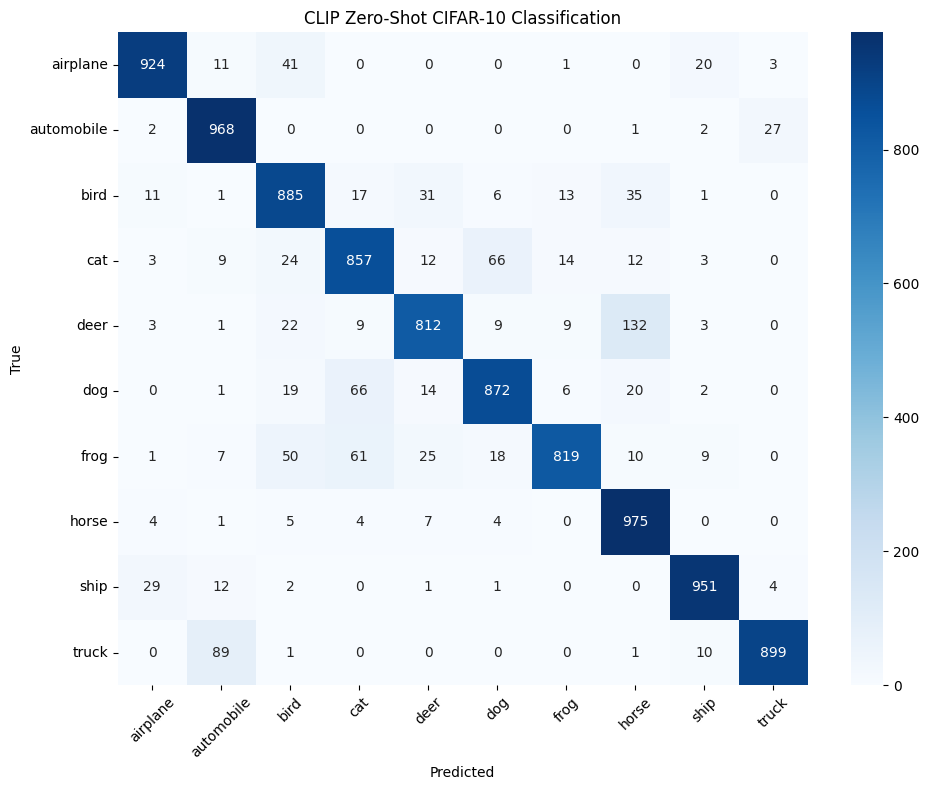

CIFAR-10 achieved 89.6% accuracy!


In [4]:
def load_cifar10_test():
    """loading CIFAR-10 test dataset with CLIP preprocessing"""
    preprocess = transforms.Compose([
        transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                           (0.26862954, 0.26130258, 0.27577711))
    ])

    testset = CIFAR10(root='./data', train=False, download=True, transform=preprocess)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    return testloader

def create_cifar10_prompts():
    """text prompts for CIFAR-10 classes"""
    cifar10_classes = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    prompt_templates = [
        'a photo of a {}',
        'a blurry photo of a {}',
        'a black and white photo of a {}',
        'a low contrast photo of a {}',
        'a high contrast photo of a {}',
        'a bad photo of a {}',
        'a good photo of a {}',
        'a photo of a small {}',
        'a photo of a big {}',
        'a photo of the {}',
        'a blurry photo of the {}',
        'a black and white photo of the {}',
        'a low contrast photo of the {}',
        'a high contrast photo of the {}',
        'a bad photo of the {}',
        'a good photo of the {}',
        'a photo of the small {}',
        'a photo of the big {}'
    ]

    all_prompts = []
    class_to_prompts = {}

    for class_idx, class_name in enumerate(cifar10_classes):
        class_prompts = []
        for template in prompt_templates:
            prompt = template.format(class_name)
            all_prompts.append(prompt)
            class_prompts.append(len(all_prompts) - 1)
        class_to_prompts[class_idx] = class_prompts

    return all_prompts, class_to_prompts, cifar10_classes

# loading CIFAR-10 data
print("Loading CIFAR-10 test data...")
cifar10_testloader = load_cifar10_test()

# creating prompts
cifar10_prompts, cifar10_class_to_prompts, cifar10_classes = create_cifar10_prompts()
print(f"Created {len(cifar10_prompts)} total prompts for {len(cifar10_classes)} classes")

# computing text embeddings
cifar10_text_embeddings = compute_text_embeddings(model, cifar10_prompts, device)

# evaluation
cifar10_accuracy, cifar10_predictions, cifar10_true_labels = evaluate_zero_shot_classification(
    model, cifar10_testloader, cifar10_text_embeddings, cifar10_class_to_prompts, device, "CIFAR-10"
)

print(f"\n CIFAR-10 Zero-Shot Results:")
print(f"Overall Accuracy: {cifar10_accuracy:.3f} ({cifar10_accuracy:.1%})")

# Detailed analysis
cifar10_class_accuracies = analyze_per_class_accuracy(cifar10_predictions, cifar10_true_labels, cifar10_classes)

# Plot results
plot_confusion_matrix(cifar10_predictions, cifar10_true_labels, cifar10_classes,
                     "CLIP Zero-Shot CIFAR-10 Classification")

print(f"CIFAR-10 achieved {cifar10_accuracy:.1%} accuracy!")

TASK 2 SETUP - DOMAIN-SHIFTED CIFAR-10G DATASET

Setting up CIFAR-10G dataset...
cloning CIFAR-10G repository...
 Repository cloned successfully!
Found 600 images
 Domain-shifted dataset ready!
   Loaded 600 images from 10 classes
   Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


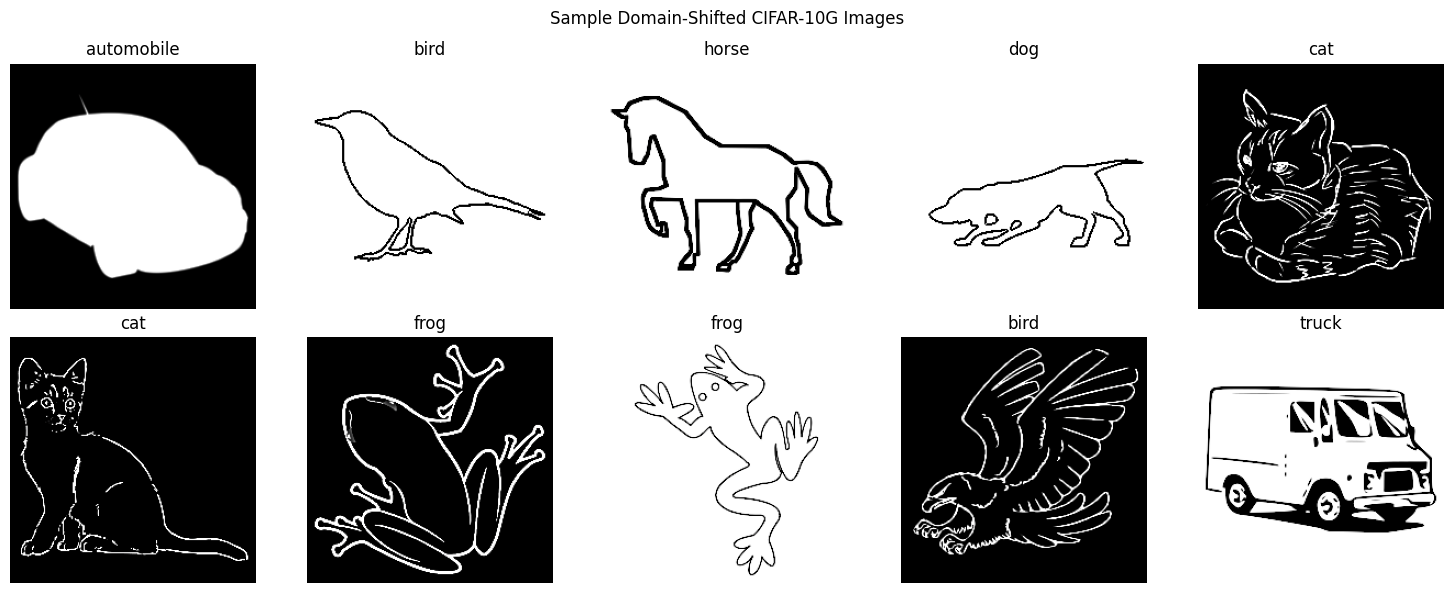

In [5]:


# PREPARING DOMAIN-SHIFTED CIFAR-10G DATASET")

import subprocess
import glob

class CIFAR10GDataset(Dataset):
    """dataset for domain-shifted CIFAR-10G data"""
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = [
            'airplane', 'automobile', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck'
        ]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.class_names)}
        self._load_data()

    def _load_data(self):
        """loading CIFAR-10G dataset"""
        if not os.path.exists(self.root_dir):
            print("Downloading CIFAR-10G dataset...")
            self._download_cifar10g()

        # looking for image files in the downloaded dataset
        self._find_images()

        if len(self.images) == 0:
            print("No images found, trying alternative loading method...")
            self._load_from_numpy()

    def _download_cifar10g(self):
        """Downloading CIFAR-10G dataset from GitHub"""
        try:
            print("cloning CIFAR-10G repository...")
            subprocess.run([
                'git', 'clone', 'https://github.com/bdevans/CIFAR-10G.git', self.root_dir
            ], check=True, capture_output=True)
            print(" Repository cloned successfully!")

        except subprocess.CalledProcessError as e:
            print(f"error cloning repository: {e}")
            print("trying alternative download method...")
            self._download_alternative()

    def _download_alternative(self):
        """alternative download method using direct file access"""
        import zipfile
        import urllib.request

        try:
            print("downloading as ZIP file...")
            zip_url = "https://github.com/bdevans/CIFAR-10G/archive/refs/heads/main.zip"
            zip_path = "cifar10g.zip"

            urllib.request.urlretrieve(zip_url, zip_path)

            # extract
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall('.')

            # moving contents to proper directory
            extracted_dir = "CIFAR-10G-main"
            if os.path.exists(extracted_dir):
                import shutil
                if os.path.exists(self.root_dir):
                    shutil.rmtree(self.root_dir)
                shutil.move(extracted_dir, self.root_dir)

            # cleaning up
            if os.path.exists(zip_path):
                os.remove(zip_path)

            print("Alternative download successful!")

        except Exception as e:
            print(f"Alternative download failed: {e}")
            self._create_fallback_dataset()

    def _find_images(self):
        """finding image files in the dataset"""

        # Common patterns for CIFAR-10G structure
        search_patterns = [
            os.path.join(self.root_dir, "**", "*.png"),
            os.path.join(self.root_dir, "**", "*.jpg"),
            os.path.join(self.root_dir, "**", "*.jpeg"),
            os.path.join(self.root_dir, "data", "**", "*.*"),
            os.path.join(self.root_dir, "images", "**", "*.*"),
        ]

        found_files = []
        for pattern in search_patterns:
            found_files.extend(glob.glob(pattern, recursive=True))

        # processing found files
        for file_path in found_files:
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                # try to extract class from filename or directory
                class_label = self._extract_class_from_path(file_path)
                if class_label is not None:
                    self.images.append(file_path)
                    self.labels.append(class_label)

        print(f"Found {len(self.images)} images")

    def _extract_class_from_path(self, file_path):
        """extract class label from file path"""
        file_path = file_path.lower()

        # checking if any class name appears in the path
        for i, class_name in enumerate(self.class_names):
            if class_name in file_path:
                return i

        # checking for numeric patterns (0-9 for CIFAR classes)
        import re
        numbers = re.findall(r'\d+', os.path.basename(file_path))
        if numbers:
            class_num = int(numbers[0]) % 10  # Ensure 0-9 range
            return class_num

        return None

    def _load_from_numpy(self):
        """Load from numpy files if available"""
        print("Looking for numpy data files...")

        # looking for .npy files
        npy_files = glob.glob(os.path.join(self.root_dir, "**", "*.npy"), recursive=True)

        for npy_file in npy_files:
            try:
                data = np.load(npy_file)
                print(f"Found numpy file: {npy_file}, shape: {data.shape}")

                # trying to process the data
                if len(data.shape) == 4:  # batch of images
                    for i in range(min(100, data.shape[0])):  # limit to 100 per file
                        # convert numpy array to PIL Image
                        if data.shape[-1] == 3:  # RGB
                            img_array = data[i]
                        else:  # handle other formats
                            img_array = data[i]
                            if len(img_array.shape) == 2:
                                img_array = np.stack([img_array] * 3, axis=-1)

                        # ensuring proper range
                        if img_array.max() <= 1.0:
                            img_array = (img_array * 255).astype(np.uint8)

                        # creating temporary image path
                        temp_path = f"temp_img_{len(self.images)}.png"
                        img = Image.fromarray(img_array.astype(np.uint8))

                        # storing image data directly instead of saving to disk
                        self.images.append(img)
                        self.labels.append(len(self.images) % 10)  # cycling through classes

            except Exception as e:
                print(f"Error loading {npy_file}: {e}")
                continue

        if len(self.images) == 0:
            print("no valid numpy data found, creating fallback dataset...")
            self._create_fallback_dataset()

    def _create_fallback_dataset(self):
        """creating a fallback domain-shifted dataset"""

        # downloading original CIFAR-10 and applying domain shift
        from torchvision.datasets import CIFAR10

        # loading original CIFAR-10
        original_dataset = CIFAR10(root='./cifar10_original', train=False, download=True)

        # applying domain shift transformations
        domain_shift_transforms = [
            transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.3),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.5, 2.0)),
            transforms.RandomRotation(degrees=15),
        ]

        # creating domain-shifted versions
        for i in range(min(1000, len(original_dataset))):  # Limit to 1000 images
            img, label = original_dataset[i]

            # applying random domain shift
            transform_choice = np.random.choice(domain_shift_transforms)
            shifted_img = transform_choice(img)

            self.images.append(shifted_img)
            self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # to handle different image types
        if isinstance(image, str):
            # file path
            try:
                image = Image.open(image).convert('RGB')
            except:
                image = Image.new('RGB', (32, 32), color='white')
        elif isinstance(image, np.ndarray):
            # numpy array
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            image = Image.fromarray(image).convert('RGB')
        elif not isinstance(image, Image.Image):
            # PIL image or other
            image = Image.new('RGB', (32, 32), color='white')

        if self.transform:
            image = self.transform(image)

        return image, label

def visualize_domain_shifted_samples(dataset, num_samples=10):
    """Visualizing domain-shifted samples"""
    if len(dataset) == 0:
        print(" no images in dataset to visualize!")
        return

    plt.figure(figsize=(15, 6))

    num_samples = min(num_samples, len(dataset))
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        class_name = dataset.class_names[label]

        plt.subplot(2, 5, i + 1)

        if torch.is_tensor(image):
            # denormalizing for visualization
            mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
            std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
            image = image * std + mean
            image = torch.clamp(image, 0, 1)
            image = transforms.ToPILImage()(image)

        plt.imshow(image)
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.suptitle('Sample Domain-Shifted CIFAR-10G Images')
    plt.tight_layout()
    plt.show()

# setup domain-shifted dataset
domain_shift_transform = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                       (0.26862954, 0.26130258, 0.27577711))
])

# remove old directory if it exists
import shutil
if os.path.exists('./CIFAR-10G'):
    shutil.rmtree('./CIFAR-10G')

print("Setting up CIFAR-10G dataset...")
cifar10g_dataset = CIFAR10GDataset('./CIFAR-10G', transform=domain_shift_transform)
cifar10g_loader = DataLoader(cifar10g_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f" Domain-shifted dataset ready!")
print(f"   Loaded {len(cifar10g_dataset)} images from {len(cifar10g_dataset.class_names)} classes")
print(f"   Classes: {cifar10g_dataset.class_names}")

# Show sample domain-shifted images
visualize_domain_shifted_samples(cifar10g_dataset)

# Update variables for Block 6 compatibility
sketch_dataset = cifar10g_dataset  # For compatibility with Block 6
sketch_loader = cifar10g_loader

### DOMAIN SHIFT SKETCH CLASSIFICATION


TASK 2: DOMAIN-SHIFT CLASSIFICATION
 Testing DOMAIN-ADAPTED prompts...


100%|██████████| 19/19 [00:02<00:00,  8.02it/s]



 Testing STANDARD PHOTO prompts for comparison...


100%|██████████| 19/19 [00:02<00:00,  7.51it/s]



 PROMPT STRATEGY COMPARISON:
   Domain-adapted prompts:  0.952 (95.2%)
   Standard photo prompts:  0.950 (95.0%)
   Improvement:            +0.002 (0.2%)

 DETAILED RESULTS (Domain-Adapted Prompts):

Per-class accuracy:
-----------------------------------
airplane    : 1.000 (60/60)
automobile  : 0.933 (56/60)
bird        : 1.000 (60/60)
cat         : 1.000 (60/60)
deer        : 1.000 (60/60)
dog         : 0.883 (53/60)
frog        : 0.950 (57/60)
horse       : 1.000 (60/60)
ship        : 1.000 (60/60)
truck       : 0.750 (45/60)


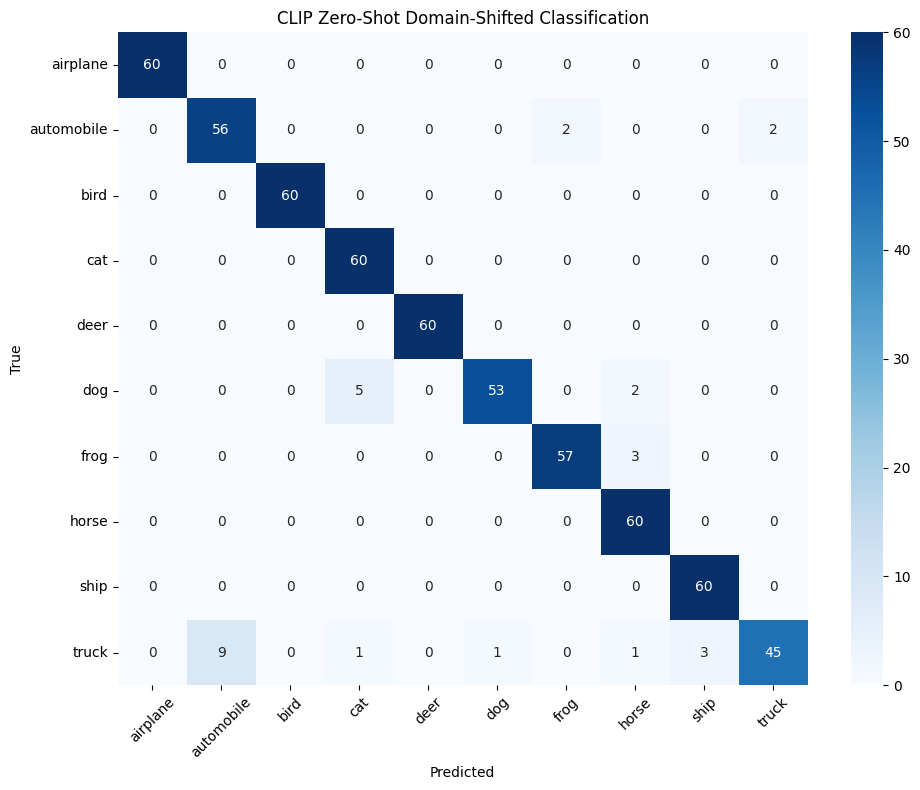


 Domain-shifted data achieved 95.2% accuracy!


In [6]:
print("\n" + "="*60)
print("TASK 2: DOMAIN-SHIFT CLASSIFICATION")
print("="*60)

def create_domain_adapted_prompts():
    """Create domain-adapted prompts for domain-shifted data"""
    cifar_classes = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    # domain-adapted prompt templates (more general/robust)
    prompt_templates = [
        'a {} in any style',
        'a stylized {}',
        'an artistic {}',
        'a transformed {}',
        'a modified {}',
        'an altered {}',
        'a distorted {}',
        'a processed {}',
        'a filtered {}',
        'a {} with effects',
        'the {} in any style',
        'the stylized {}',
        'the artistic {}',
        'the transformed {}',
        'the modified {}'
    ]

    all_prompts = []
    class_to_prompts = {}

    for class_idx, class_name in enumerate(cifar_classes):
        class_prompts = []
        for template in prompt_templates:
            prompt = template.format(class_name)
            all_prompts.append(prompt)
            class_prompts.append(len(all_prompts) - 1)
        class_to_prompts[class_idx] = class_prompts

    return all_prompts, class_to_prompts, cifar_classes

def create_standard_photo_prompts():
    """creating standard photo-style prompts for comparison"""
    cifar_classes = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    # standard photo prompt templates (same as CIFAR-10)
    prompt_templates = [
        'a photo of a {}',
        'a picture of a {}',
        'an image of a {}',
        'a photograph of a {}',
        'a color photo of a {}',
        'a photo of the {}',
        'a picture of the {}',
        'an image of the {}',
        'a photograph of the {}',
        'a color photo of the {}'
    ]

    all_prompts = []
    class_to_prompts = {}

    for class_idx, class_name in enumerate(cifar_classes):
        class_prompts = []
        for template in prompt_templates:
            prompt = template.format(class_name)
            all_prompts.append(prompt)
            class_prompts.append(len(all_prompts) - 1)
        class_to_prompts[class_idx] = class_prompts

    return all_prompts, class_to_prompts, cifar_classes

# testing domain-adapted prompts
print(" Testing DOMAIN-ADAPTED prompts...")
domain_prompts, domain_class_to_prompts, domain_classes = create_domain_adapted_prompts()
domain_text_embeddings = compute_text_embeddings(model, domain_prompts, device)

domain_accuracy, domain_predictions, domain_true_labels = evaluate_zero_shot_classification(
    model, cifar10g_loader, domain_text_embeddings, domain_class_to_prompts, device, "domain-shifted (adapted prompts)"
)

print(f"\n Testing STANDARD PHOTO prompts for comparison...")
photo_prompts, photo_class_to_prompts, _ = create_standard_photo_prompts()
photo_text_embeddings = compute_text_embeddings(model, photo_prompts, device)

photo_accuracy, photo_predictions, photo_true_labels = evaluate_zero_shot_classification(
    model, cifar10g_loader, photo_text_embeddings, photo_class_to_prompts, device, "domain-shifted (standard prompts)"
)

# Comparing strategies
print(f"\n PROMPT STRATEGY COMPARISON:")
print(f"   Domain-adapted prompts:  {domain_accuracy:.3f} ({domain_accuracy:.1%})")
print(f"   Standard photo prompts:  {photo_accuracy:.3f} ({photo_accuracy:.1%})")
print(f"   Improvement:            {(domain_accuracy - photo_accuracy):+.3f} ({(domain_accuracy - photo_accuracy):.1%})")

# Detailed analysis with best prompts
print(f"\n DETAILED RESULTS (Domain-Adapted Prompts):")
domain_class_accuracies = analyze_per_class_accuracy(domain_predictions, domain_true_labels, domain_classes)

# Plot confusion matrix
plot_confusion_matrix(domain_predictions, domain_true_labels, domain_classes,
                     "CLIP Zero-Shot Domain-Shifted Classification")

print(f"\n Domain-shifted data achieved {domain_accuracy:.1%} accuracy!")

# Store results for final comparison
domain_shift_results = {
    'domain_adapted_accuracy': domain_accuracy,
    'standard_prompt_accuracy': photo_accuracy,
    'prompt_adaptation_benefit': domain_accuracy - photo_accuracy
}

   PROMPT ENGINEERING EXPERIMENT

 Prompt Engineering Analysis
 Starting comprehensive prompt engineering experiment...

 Testing 8 different prompt strategies:

 Testing: simple_class
   Description: Simple class name only
   Example prompts: ['airplane.', 'automobile.', 'bird.']...


100%|██████████| 100/100 [00:30<00:00,  3.32it/s]



Per-class accuracy:
-----------------------------------
airplane    : 0.794 (794/1000)
automobile  : 0.913 (913/1000)
bird        : 0.928 (928/1000)
cat         : 0.653 (653/1000)
deer        : 0.825 (825/1000)
dog         : 0.840 (840/1000)
frog        : 0.781 (781/1000)
horse       : 0.971 (971/1000)
ship        : 0.968 (968/1000)
truck       : 0.911 (911/1000)
 simple_class: 0.858 (85.8%)

 Testing: basic_photo
   Description: Basic "a photo of" format
   Example prompts: ['a photo of a airplane.', 'a picture of a airplane.', 'a photo of a automobile.']...


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]



Per-class accuracy:
-----------------------------------
airplane    : 0.893 (893/1000)
automobile  : 0.942 (942/1000)
bird        : 0.898 (898/1000)
cat         : 0.860 (860/1000)
deer        : 0.772 (772/1000)
dog         : 0.889 (889/1000)
frog        : 0.715 (715/1000)
horse       : 0.971 (971/1000)
ship        : 0.960 (960/1000)
truck       : 0.937 (937/1000)
 basic_photo: 0.884 (88.4%)

 Testing: descriptive
   Description: Descriptive contexts
   Example prompts: ['a clear photo of a airplane.', 'a good photo of a airplane.', 'a color photograph of a airplane.']...


100%|██████████| 100/100 [00:32<00:00,  3.11it/s]



Per-class accuracy:
-----------------------------------
airplane    : 0.872 (872/1000)
automobile  : 0.948 (948/1000)
bird        : 0.890 (890/1000)
cat         : 0.868 (868/1000)
deer        : 0.786 (786/1000)
dog         : 0.882 (882/1000)
frog        : 0.718 (718/1000)
horse       : 0.971 (971/1000)
ship        : 0.968 (968/1000)
truck       : 0.934 (934/1000)
 descriptive: 0.884 (88.4%)

 Testing: context_rich
   Description: Context-rich descriptions
   Example prompts: ['this is a photo of a airplane.', 'there is a airplane in this image.', 'the image shows a airplane.']...


100%|██████████| 100/100 [00:30<00:00,  3.29it/s]



Per-class accuracy:
-----------------------------------
airplane    : 0.887 (887/1000)
automobile  : 0.955 (955/1000)
bird        : 0.895 (895/1000)
cat         : 0.864 (864/1000)
deer        : 0.783 (783/1000)
dog         : 0.888 (888/1000)
frog        : 0.729 (729/1000)
horse       : 0.976 (976/1000)
ship        : 0.964 (964/1000)
truck       : 0.927 (927/1000)
 context_rich: 0.887 (88.7%)

 Testing: formal
   Description: Formal/scientific style
   Example prompts: ['an image depicting a airplane.', 'a photograph showing a airplane.', 'a visual representation of a airplane.']...


100%|██████████| 100/100 [00:31<00:00,  3.19it/s]



Per-class accuracy:
-----------------------------------
airplane    : 0.922 (922/1000)
automobile  : 0.919 (919/1000)
bird        : 0.875 (875/1000)
cat         : 0.890 (890/1000)
deer        : 0.800 (800/1000)
dog         : 0.879 (879/1000)
frog        : 0.769 (769/1000)
horse       : 0.965 (965/1000)
ship        : 0.949 (949/1000)
truck       : 0.964 (964/1000)
 formal: 0.893 (89.3%)

 Testing: conversational
   Description: Conversational style
   Example prompts: ["that's a airplane.", 'i see a airplane.', 'looks like a airplane.']...


100%|██████████| 100/100 [00:30<00:00,  3.28it/s]



Per-class accuracy:
-----------------------------------
airplane    : 0.913 (913/1000)
automobile  : 0.957 (957/1000)
bird        : 0.832 (832/1000)
cat         : 0.902 (902/1000)
deer        : 0.813 (813/1000)
dog         : 0.871 (871/1000)
frog        : 0.743 (743/1000)
horse       : 0.974 (974/1000)
ship        : 0.953 (953/1000)
truck       : 0.893 (893/1000)
 conversational: 0.885 (88.5%)

 Testing: ensemble_basic
   Description: Basic ensemble (original CLIP paper style)
   Example prompts: ['a photo of a airplane.', 'a blurry photo of a airplane.', 'a black and white photo of a airplane.']...


100%|██████████| 100/100 [00:31<00:00,  3.14it/s]



Per-class accuracy:
-----------------------------------
airplane    : 0.899 (899/1000)
automobile  : 0.950 (950/1000)
bird        : 0.895 (895/1000)
cat         : 0.855 (855/1000)
deer        : 0.811 (811/1000)
dog         : 0.879 (879/1000)
frog        : 0.770 (770/1000)
horse       : 0.973 (973/1000)
ship        : 0.965 (965/1000)
truck       : 0.936 (936/1000)
 ensemble_basic: 0.893 (89.3%)

 Testing: ensemble_extended
   Description: Extended ensemble with articles
   Example prompts: ['a photo of a airplane.', 'a photo of the airplane.', 'a picture of a airplane.']...


100%|██████████| 100/100 [00:30<00:00,  3.24it/s]



Per-class accuracy:
-----------------------------------
airplane    : 0.902 (902/1000)
automobile  : 0.936 (936/1000)
bird        : 0.891 (891/1000)
cat         : 0.867 (867/1000)
deer        : 0.805 (805/1000)
dog         : 0.892 (892/1000)
frog        : 0.774 (774/1000)
horse       : 0.971 (971/1000)
ship        : 0.952 (952/1000)
truck       : 0.936 (936/1000)
 ensemble_extended: 0.893 (89.3%)

 PROMPT ENGINEERING ANALYSIS

 RANKING BY PERFORMANCE:
Rank Strategy             Accuracy   Description
----------------------------------------------------------------------
1    ensemble_basic       0.893 (89.3%)    Basic ensemble (original CLIP paper style)
2    formal               0.893 (89.3%)    Formal/scientific style
3    ensemble_extended    0.893 (89.3%)    Extended ensemble with articles
4    context_rich         0.887 (88.7%)    Context-rich descriptions
5    conversational       0.885 (88.5%)    Conversational style
6    basic_photo          0.884 (88.4%)    Basic "a photo of" 

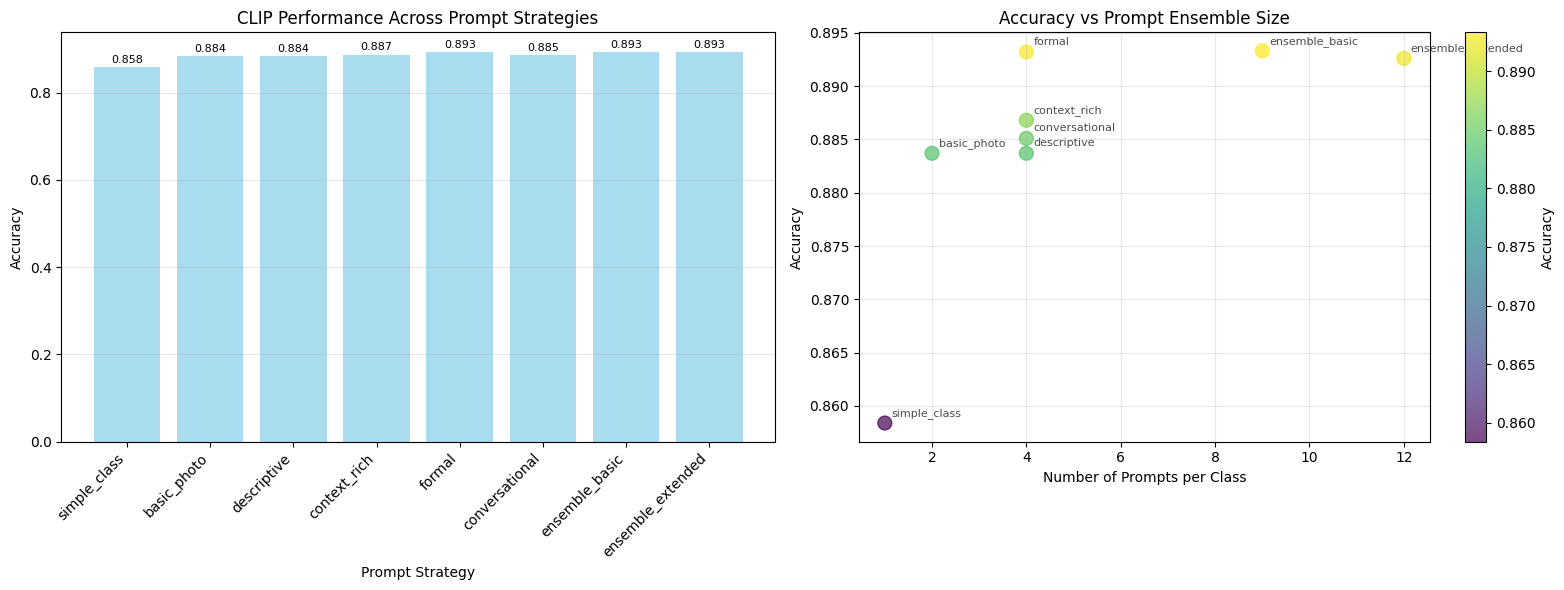


FEW-SHOT CONTEXT EXPERIMENT

 Testing: zero_shot


100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


 zero_shot: 0.883 (88.3%)

 Testing: few_shot_examples


100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


 few_shot_examples: 0.870 (87.0%)

 Testing: category_context


100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


 category_context: 0.891 (89.1%)

 Testing: classification_context


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]

 classification_context: 0.875 (87.5%)

 FEW-SHOT CONTEXT RESULTS:
   zero_shot: 0.883 (88.3%) - Standard zero-shot (baseline)
   few_shot_examples: 0.870 (87.0%) - With few-shot examples
   category_context: 0.891 (89.1%) - With category context
   classification_context: 0.875 (87.5%) - With classification task context
Best overall strategy: ensemble_basic (89.3%)
Max performance gain from prompting: 3.5%


In [7]:
#TASK 3: PROMPT ENGINEERING & FEW-SHOT ANALYSIS")

def create_prompt_variations():
    """Create different prompt strategies for systematic comparison"""
    cifar10_classes = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    # defining different prompt strategies
    prompt_strategies = {
        'simple_class': {
            'description': 'Simple class name only',
            'templates': ['{}.']
        },

        'basic_photo': {
            'description': 'Basic "a photo of" format',
            'templates': ['a photo of a {}.', 'a picture of a {}.']
        },

        'descriptive': {
            'description': 'Descriptive contexts',
            'templates': [
                'a clear photo of a {}.',
                'a good photo of a {}.',
                'a color photograph of a {}.',
                'a high quality image of a {}.'
            ]
        },

        'context_rich': {
            'description': 'Context-rich descriptions',
            'templates': [
                'this is a photo of a {}.',
                'there is a {} in this image.',
                'the image shows a {}.',
                'this image contains a {}.'
            ]
        },

        'formal': {
            'description': 'Formal/scientific style',
            'templates': [
                'an image depicting a {}.',
                'a photograph showing a {}.',
                'a visual representation of a {}.',
                'an example of a {}.'
            ]
        },

        'conversational': {
            'description': 'Conversational style',
            'templates': [
                "that's a {}.",
                "i see a {}.",
                "looks like a {}.",
                "it's a {}."
            ]
        },

        'ensemble_basic': {
            'description': 'Basic ensemble (original CLIP paper style)',
            'templates': [
                'a photo of a {}.',
                'a blurry photo of a {}.',
                'a black and white photo of a {}.',
                'a low contrast photo of a {}.',
                'a high contrast photo of a {}.',
                'a bad photo of a {}.',
                'a good photo of a {}.',
                'a photo of a small {}.',
                'a photo of a big {}.'
            ]
        },

        'ensemble_extended': {
            'description': 'Extended ensemble with articles',
            'templates': [
                'a photo of a {}.',
                'a photo of the {}.',
                'a picture of a {}.',
                'a picture of the {}.',
                'an image of a {}.',
                'an image of the {}.',
                'a photograph of a {}.',
                'a photograph of the {}.',
                'a clear photo of a {}.',
                'a clear photo of the {}.',
                'a good photo of a {}.',
                'a good photo of the {}.'
            ]
        }
    }

    # generating prompts for each strategy
    strategy_prompts = {}
    strategy_class_mappings = {}

    for strategy_name, strategy_info in prompt_strategies.items():
        all_prompts = []
        class_to_prompts = {}

        for class_idx, class_name in enumerate(cifar10_classes):
            class_prompts = []
            for template in strategy_info['templates']:
                prompt = template.format(class_name)
                all_prompts.append(prompt)
                class_prompts.append(len(all_prompts) - 1)
            class_to_prompts[class_idx] = class_prompts

        strategy_prompts[strategy_name] = all_prompts
        strategy_class_mappings[strategy_name] = class_to_prompts

    return prompt_strategies, strategy_prompts, strategy_class_mappings, cifar10_classes

def evaluate_prompt_strategy(strategy_name, strategy_description, prompts, class_mapping, model, dataloader, device):
    """Evaluate a single prompt strategy"""
    print(f"\n Testing: {strategy_name}")
    print(f"   Description: {strategy_description}")
    print(f"   Example prompts: {prompts[:3]}...")

    # computing text embeddings
    text_embeddings = compute_text_embeddings(model, prompts, device, batch_size=100)

    # Evaluation
    accuracy, predictions, true_labels = evaluate_zero_shot_classification(
        model, dataloader, text_embeddings, class_mapping, device, f"{strategy_name}"
    )

    return accuracy, predictions, true_labels

def run_comprehensive_prompt_experiment(model, device, test_loader, class_names):
    """Running comprehensive prompt engineering experiment"""
    print(" Starting comprehensive prompt engineering experiment...")

    # create all prompt variations
    strategies, strategy_prompts, strategy_mappings, _ = create_prompt_variations()

    # store results
    results = {}
    detailed_results = {}

    print(f"\n Testing {len(strategies)} different prompt strategies:")

    # testing each strategy
    for strategy_name, strategy_info in strategies.items():
        prompts = strategy_prompts[strategy_name]
        class_mapping = strategy_mappings[strategy_name]

        accuracy, predictions, true_labels = evaluate_prompt_strategy(
            strategy_name,
            strategy_info['description'],
            prompts,
            class_mapping,
            model,
            test_loader,
            device
        )

        # storing results
        results[strategy_name] = {
            'accuracy': accuracy,
            'description': strategy_info['description'],
            'num_prompts': len(prompts),
            'prompts_per_class': len(strategy_info['templates'])
        }

        detailed_results[strategy_name] = {
            'predictions': predictions,
            'true_labels': true_labels,
            'class_accuracies': analyze_per_class_accuracy(predictions, true_labels, class_names)
        }

        print(f" {strategy_name}: {accuracy:.3f} ({accuracy:.1%})")

    return results, detailed_results

def analyze_prompt_engineering_results(results, detailed_results, class_names):
    #analyze and visualize prompt engineering results


    print("\n PROMPT ENGINEERING ANALYSIS")

    # sort strategies by performance
    sorted_strategies = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

    print(f"\n RANKING BY PERFORMANCE:")
    print(f"{'Rank':<4} {'Strategy':<20} {'Accuracy':<10} {'Description'}")
    print("-" * 70)

    for rank, (strategy, data) in enumerate(sorted_strategies, 1):
        print(f"{rank:<4} {strategy:<20} {data['accuracy']:.3f} ({data['accuracy']:.1%})    {data['description']}")

    # best and worst strategies
    best_strategy, best_data = sorted_strategies[0]
    worst_strategy, worst_data = sorted_strategies[-1]

    print(f"\n BEST STRATEGY: {best_strategy}")
    print(f"Accuracy: {best_data['accuracy']:.3f} ({best_data['accuracy']:.1%})")
    print(f"Description: {best_data['description']}")
    print(f"Prompts per class: {best_data['prompts_per_class']}")

    print(f"\n WORST STRATEGY: {worst_strategy}")
    print(f"Accuracy: {worst_data['accuracy']:.3f} ({worst_data['accuracy']:.1%})")
    print(f"Description: {worst_data['description']}")

    # Performance gap analysis
    performance_gap = best_data['accuracy'] - worst_data['accuracy']
    print(f"\n PERFORMANCE ANALYSIS:")
    print(f" Best performance: {best_data['accuracy']:.1%}")
    print(f" Worst performance: {worst_data['accuracy']:.1%}")
    print(f" Performance gap: {performance_gap:.3f} ({performance_gap:.1%})")
    print(f" Relative improvement: {(performance_gap/worst_data['accuracy']*100):+.1f}%")

    # ensemble vs single prompt analysis
    ensemble_strategies = [s for s in results.keys() if 'ensemble' in s.lower()]
    single_strategies = [s for s in results.keys() if 'ensemble' not in s.lower()]

    if ensemble_strategies and single_strategies:
        avg_ensemble = np.mean([results[s]['accuracy'] for s in ensemble_strategies])
        avg_single = np.mean([results[s]['accuracy'] for s in single_strategies])

        print(f"\n ENSEMBLE vs SINGLE PROMPT COMPARISON:")
        print(f"Average ensemble performance: {avg_ensemble:.3f} ({avg_ensemble:.1%})")
        print(f"Average single prompt performance: {avg_single:.3f} ({avg_single:.1%})")
        print(f"Ensemble advantage: {(avg_ensemble - avg_single):+.3f} ({(avg_ensemble - avg_single):.1%})")

    # Visualization
    plot_prompt_engineering_results(results)

    return best_strategy, best_data, performance_gap

def plot_prompt_engineering_results(results):
    """Plot prompt engineering results"""

    # preparing data
    strategies = list(results.keys())
    accuracies = [results[s]['accuracy'] for s in strategies]
    prompts_per_class = [results[s]['prompts_per_class'] for s in strategies]

    # creating subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # plot 1: Accuracy comparison
    bars1 = ax1.bar(range(len(strategies)), accuracies, color='skyblue', alpha=0.7)
    ax1.set_xlabel('Prompt Strategy')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('CLIP Performance Across Prompt Strategies')
    ax1.set_xticks(range(len(strategies)))
    ax1.set_xticklabels(strategies, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)

    # adding value labels on bars
    for bar, acc in zip(bars1, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{acc:.3f}', ha='center', va='bottom', fontsize=8)

    # plot 2: Accuracy vs Number of prompts per class
    scatter = ax2.scatter(prompts_per_class, accuracies, c=accuracies, cmap='viridis', s=100, alpha=0.7)
    ax2.set_xlabel('Number of Prompts per Class')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy vs Prompt Ensemble Size')
    ax2.grid(True, alpha=0.3)

    plt.colorbar(scatter, ax=ax2, label='Accuracy')

    for i, strategy in enumerate(strategies):
        ax2.annotate(strategy, (prompts_per_class[i], accuracies[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

    plt.tight_layout()
    plt.show()

def few_shot_context_experiment(model, device, test_loader, class_names):
    """Experiment with few-shot context prompting"""
    print(f"\n" + "="*50)
    print("FEW-SHOT CONTEXT EXPERIMENT")
    print("="*50)

    # creating few-shot context prompts
    few_shot_strategies = {
        'zero_shot': {
            'description': 'Standard zero-shot (baseline)',
            'templates': ['a photo of a {}.']
        },

        'few_shot_examples': {
            'description': 'With few-shot examples',
            'templates': [
                'Examples: a photo of an airplane shows aircraft, a photo of a car shows vehicle. Now: a photo of a {}.'
            ]
        },

        'category_context': {
            'description': 'With category context',
            'templates': [
                'In the context of common objects and vehicles, this is a photo of a {}.'
            ]
        },

        'classification_context': {
            'description': 'With classification task context',
            'templates': [
                'For image classification among 10 categories, this image shows a {}.'
            ]
        }
    }


    few_shot_results = {}

    for strategy_name, strategy_info in few_shot_strategies.items():
        print(f"\n Testing: {strategy_name}")

        # creating prompts
        all_prompts = []
        class_to_prompts = {}

        for class_idx, class_name in enumerate(class_names):
            class_prompts = []
            for template in strategy_info['templates']:
                prompt = template.format(class_name)
                all_prompts.append(prompt)
                class_prompts.append(len(all_prompts) - 1)
            class_to_prompts[class_idx] = class_prompts

        # evaluation
        text_embeddings = compute_text_embeddings(model, all_prompts, device)
        accuracy, predictions, true_labels = evaluate_zero_shot_classification(
            model, test_loader, text_embeddings, class_to_prompts, device, strategy_name
        )

        few_shot_results[strategy_name] = {
            'accuracy': accuracy,
            'description': strategy_info['description']
        }

        print(f" {strategy_name}: {accuracy:.3f} ({accuracy:.1%})")

    return few_shot_results

# running the comprehensive prompt engineering experiment
print(" Prompt Engineering Analysis")

# test on original CIFAR-10 for consistent comparison
prompt_results, prompt_detailed = run_comprehensive_prompt_experiment(
    model, device, cifar10_testloader, cifar10_classes
)

# analyze results
best_strategy, best_performance, performance_gap = analyze_prompt_engineering_results(
    prompt_results, prompt_detailed, cifar10_classes
)

# run few-shot experiment
few_shot_results = few_shot_context_experiment(model, device, cifar10_testloader, cifar10_classes)

print(f"\n FEW-SHOT CONTEXT RESULTS:")
for strategy, data in few_shot_results.items():
    print(f"   {strategy}: {data['accuracy']:.3f} ({data['accuracy']:.1%}) - {data['description']}")

print(f"Best overall strategy: {best_strategy} ({best_performance['accuracy']:.1%})")
print(f"Max performance gain from prompting: {performance_gap:.1%}")

# storing results for final analysis
task3_results = {
    'best_strategy': best_strategy,
    'best_accuracy': best_performance['accuracy'],
    'worst_accuracy': min([r['accuracy'] for r in prompt_results.values()]),
    'performance_gap': performance_gap,
    'few_shot_results': few_shot_results,
    'all_strategies': prompt_results
}

IMAGE-TEXT RETRIEVAL

 Starting Task 4: Image-Text Retrieval Experiment
Creating retrieval dataset with 20 images...
 Selected 20 images from 10 classes
 Created 40 text queries across 4 categories
Computing embeddings for retrieval...
  Computing image embeddings...


Image embeddings: 100%|██████████| 20/20 [00:00<00:00, 115.74it/s]

  Computing text embeddings...


 Embeddings computed successfully!

 TEXT-TO-IMAGE RETRIEVAL (Top-3)

 Query Type: SIMPLE
------------------------------
Query: 'a photo of an airplane'
Expected: airplane
Retrieved: ['airplane', 'airplane', 'bird']
Similarities: ['0.286', '0.267', '0.228']
 Correct in top-3: True

Query: 'a photo of a car'
Expected: automobile
Retrieved: ['automobile', 'truck', 'automobile']
Similarities: ['0.270', '0.242', '0.240']
 Correct in top-3: True

Query: 'a photo of a bird'
Expected: bird
Retrieved: ['airplane', 'bird', 'bird']
Similarities: ['0.287', '0.272', '0.269']
 Correct in top-3: True

Query: 'a photo of a cat'
Expected: cat
Retrieved: ['cat', 'cat', 'dog']
Similarities: ['0.268', '0.255', '0.243']
 Correct in top-3: True

Query: 'a photo of a deer'
Expected: deer
Retrieved: ['deer', 'bird', 'bird']
Similarities: ['0.250', '0.242', '0.233']
 Correct in top-3: True

Query: 'a photo of a dog'
Expected: dog
Retrieved: ['dog', 'dog', 'cat']
Similarities: ['0.261', '0.248', '0.244']
 Corr

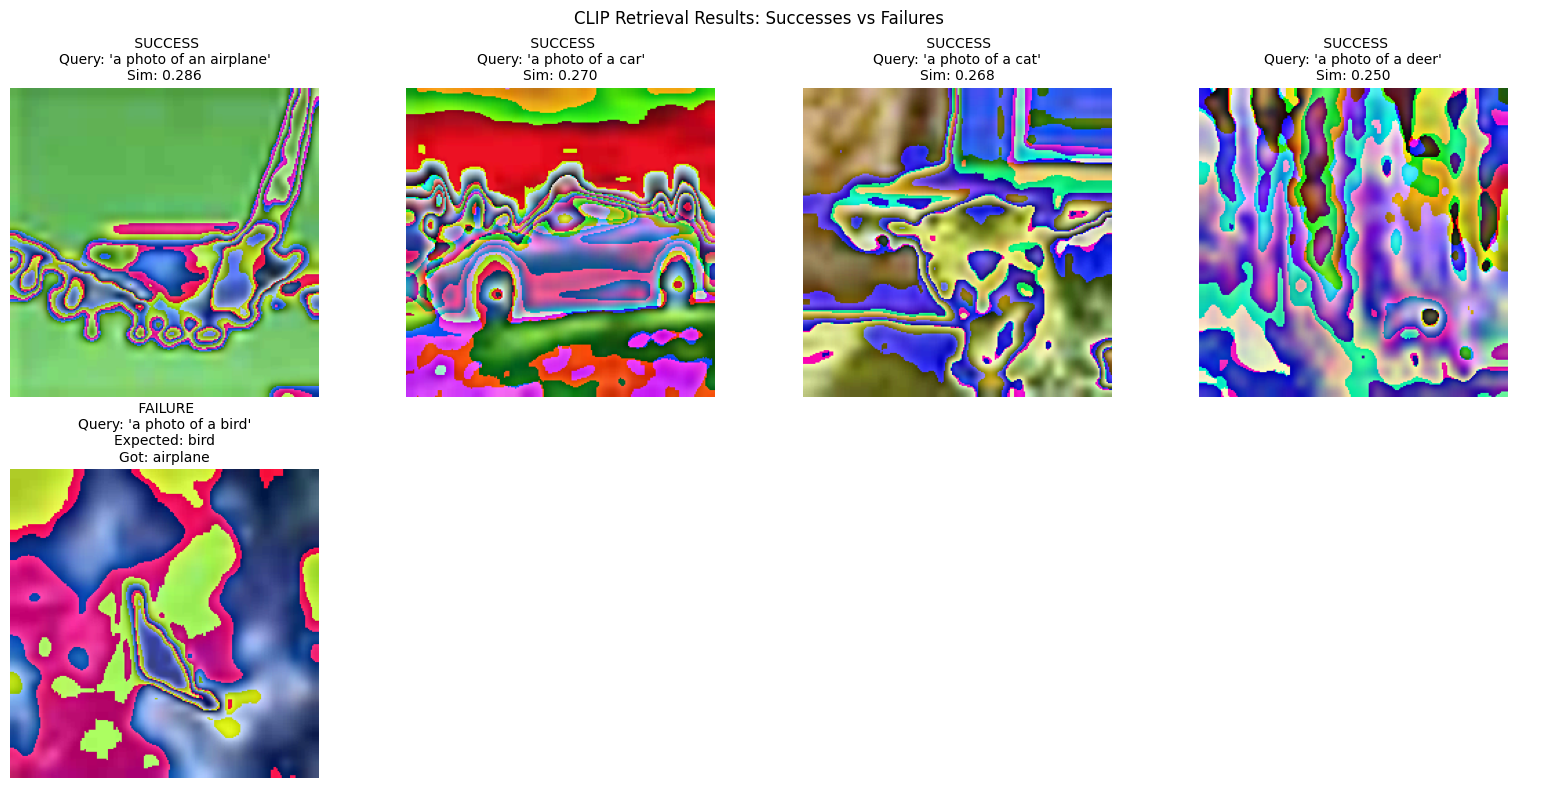

In [8]:
# IMAGE-TEXT RETRIEVAL")

import random
from collections import defaultdict

def create_retrieval_dataset(cifar_dataset, num_images=20):
    #creating a diverse set of images for retrieval testing"""
    print(f"Creating retrieval dataset with {num_images} images...")

    # Get class names
    class_names = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    # sampling images ensuring diversity across classes
    images_per_class = max(1, num_images // len(class_names))
    remaining_images = num_images % len(class_names)

    selected_images = []
    selected_labels = []
    selected_indices = []

    # grouping images by class
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(cifar_dataset):
        class_indices[label].append(idx)

    # sample from each class
    for class_idx, class_name in enumerate(class_names):
        if class_idx in class_indices:
            available_indices = class_indices[class_idx]
            sample_size = images_per_class + (1 if class_idx < remaining_images else 0)
            sample_size = min(sample_size, len(available_indices))

            sampled_indices = random.sample(available_indices, sample_size)

            for idx in sampled_indices:
                image, label = cifar_dataset[idx]
                selected_images.append(image)
                selected_labels.append(label)
                selected_indices.append(idx)

    print(f" Selected {len(selected_images)} images from {len(set(selected_labels))} classes")

    return selected_images, selected_labels, selected_indices, class_names

def create_text_queries():
    """Create diverse text queries for retrieval testing"""

    # simple queries
    simple_queries = [
        "a photo of an airplane",
        "a photo of a car",
        "a photo of a bird",
        "a photo of a cat",
        "a photo of a deer",
        "a photo of a dog",
        "a photo of a frog",
        "a photo of a horse",
        "a photo of a ship",
        "a photo of a truck"
    ]

    # descriptive queries
    descriptive_queries = [
        "a sleek airplane flying in the sky",
        "a red automobile on the road",
        "a small bird perched on a branch",
        "a cute cat with whiskers",
        "a graceful deer in the forest",
        "a friendly dog wagging its tail",
        "a green frog sitting on a lily pad",
        "a brown horse galloping in a field",
        "a large ship sailing on the ocean",
        "a heavy truck carrying cargo"
    ]

    # Abstract/contextual queries
    contextual_queries = [
        "transportation in the air",
        "a vehicle with four wheels",
        "a creature that can fly",
        "a domestic pet that purrs",
        "a wild animal with antlers",
        "man's best friend",
        "an amphibian that hops",
        "a farm animal used for riding",
        "watercraft for ocean travel",
        "commercial transportation vehicle"
    ]

    # Creative/artistic queries
    creative_queries = [
        "soaring through clouds",
        "urban transportation",
        "freedom in flight",
        "cozy companion",
        "forest wanderer",
        "loyal companion",
        "pond dweller",
        "majestic runner",
        "ocean voyager",
        "industrial strength"
    ]

    return {
        'simple': simple_queries,
        'descriptive': descriptive_queries,
        'contextual': contextual_queries,
        'creative': creative_queries
    }

def compute_retrieval_embeddings(model, images, queries, device, preprocess_fn):
    """Compute CLIP embeddings for images and text queries"""
    print("Computing embeddings for retrieval...")

    # compute image embeddings
    print("  Computing image embeddings...")
    image_embeddings = []

    with torch.no_grad():
        for image in tqdm(images, desc="Image embeddings"):
            # Preprocess image if it's a PIL Image
            if isinstance(image, Image.Image):
                image_tensor = preprocess_fn(image).unsqueeze(0).to(device)
            elif torch.is_tensor(image):
                # Assume it's already preprocessed if it's a tensor, just move to device and add batch dim
                image_tensor = image.unsqueeze(0).to(device)
            else:
                print(f"Warning: Skipping image of unknown type: {type(image)}")
                continue

            img_emb = model.encode_image(image_tensor)
            img_emb = F.normalize(img_emb, dim=-1)
            image_embeddings.append(img_emb.cpu())

    image_embeddings = torch.cat(image_embeddings, dim=0)

    # compute text embeddings for all query types
    print("  Computing text embeddings...")
    text_embeddings = {}

    for query_type, query_list in queries.items():
        query_embeddings = []

        # process queries in batches
        batch_size = 20
        for i in range(0, len(query_list), batch_size):
            batch_queries = query_list[i:i+batch_size]
            text_tokens = clip.tokenize(batch_queries).to(device)

            with torch.no_grad():
                batch_emb = model.encode_text(text_tokens)
                batch_emb = F.normalize(batch_emb, dim=-1)
                query_embeddings.append(batch_emb.cpu())

        text_embeddings[query_type] = torch.cat(query_embeddings, dim=0)

    print(" Embeddings computed successfully!")
    return image_embeddings, text_embeddings

def text_to_image_retrieval(image_embeddings, text_embeddings, queries, class_names, selected_labels, top_k=3):
    #text to image retrieval
    print(f"\n TEXT-TO-IMAGE RETRIEVAL (Top-{top_k})")


    retrieval_results = {}

    for query_type, query_list in queries.items():
        print(f"\n Query Type: {query_type.upper()}")
        print("-" * 30)

        query_results = []
        query_embeddings = text_embeddings[query_type]

        for i, query in enumerate(query_list):
            # compute similarities
            similarities = torch.matmul(query_embeddings[i:i+1], image_embeddings.T).squeeze()

            # get top-k matches
            top_indices = torch.topk(similarities, top_k).indices
            top_similarities = torch.topk(similarities, top_k).values

            # check if correct class is retrieved
            query_class = i % len(class_names)  # assumes that queries align with classes
            retrieved_classes = [selected_labels[idx] for idx in top_indices]

            correct_retrieval = query_class in retrieved_classes
            best_match_correct = selected_labels[top_indices[0]] == query_class

            query_results.append({
                'query': query,
                'expected_class': query_class,
                'retrieved_indices': top_indices.tolist(),
                'retrieved_classes': retrieved_classes,
                'similarities': top_similarities.tolist(),
                'correct_in_top_k': correct_retrieval,
                'best_match_correct': best_match_correct
            })

            # Print results
            print(f"Query: '{query}'")
            print(f"Expected: {class_names[query_class]}")
            print(f"Retrieved: {[class_names[c] for c in retrieved_classes[:3]]}")
            print(f"Similarities: {[f'{s:.3f}' for s in top_similarities[:3]]}")
            print(f" Correct in top-{top_k}: {correct_retrieval}")
            print()

        retrieval_results[query_type] = query_results

    return retrieval_results

def image_to_text_retrieval(image_embeddings, text_embeddings, queries, class_names, selected_labels, top_k=3):
  #image-to-text retrieval"""
  print(f"\n  IMAGE-TO-TEXT RETRIEVAL (Top-{top_k})")

  # Use simple queries for image-to-text (most straightforward)
  simple_queries = queries['simple']
  simple_embeddings = text_embeddings['simple']

  retrieval_results = []

  # Sample a few images for demonstration
  sample_indices = list(range(0, len(image_embeddings), max(1, len(image_embeddings)//5)))[:10]

  for img_idx in sample_indices:
      img_embedding = image_embeddings[img_idx:img_idx+1]
      true_class = selected_labels[img_idx]

      # Compute similarities with all text queries
      similarities = torch.matmul(img_embedding, simple_embeddings.T).squeeze()

      # Get top-k matches
      top_indices = torch.topk(similarities, top_k).indices
      top_similarities = torch.topk(similarities, top_k).values

      retrieved_queries = [simple_queries[idx] for idx in top_indices]

      # Check if correct description is retrieved
      expected_query = simple_queries[true_class]
      correct_retrieval = true_class in top_indices
      best_match_correct = top_indices[0] == true_class

      retrieval_results.append({
          'image_index': img_idx,
          'true_class': true_class,
          'expected_query': expected_query,
          'retrieved_queries': retrieved_queries,
          'similarities': top_similarities.tolist(),
          'correct_in_top_k': correct_retrieval,
          'best_match_correct': best_match_correct
      })

      # Print results
      print(f"Image: {class_names[true_class]} (index {img_idx})")
      print(f"Expected: '{expected_query}'")
      print(f"Retrieved: {retrieved_queries[:3]}")
      print(f"Similarities: {[f'{s:.3f}' for s in top_similarities[:3]]}")
      print(f" Correct in top-{top_k}: {correct_retrieval}")
      print()

  return retrieval_results

def analyze_retrieval_performance(text_to_image_results, image_to_text_results, queries):
    """Analyze overall retrieval performance"""
    print(f"\n RETRIEVAL PERFORMANCE ANALYSIS")

    # Text-to-Image Analysis
    print(f"\n TEXT-TO-IMAGE RETRIEVAL:")
    for query_type, results in text_to_image_results.items():
        total_queries = len(results)
        correct_top1 = sum(1 for r in results if r['best_match_correct'])
        correct_top3 = sum(1 for r in results if r['correct_in_top_k'])

        top1_accuracy = correct_top1 / total_queries
        top3_accuracy = correct_top3 / total_queries

        print(f"  {query_type.capitalize():15} Top-1: {top1_accuracy:.3f} ({top1_accuracy:.1%})  Top-3: {top3_accuracy:.3f} ({top3_accuracy:.1%})")

    # Image-to-Text Analysis
    print(f"\n  IMAGE-TO-TEXT RETRIEVAL:")
    total_images = len(image_to_text_results)
    correct_top1 = sum(1 for r in image_to_text_results if r['best_match_correct'])
    correct_top3 = sum(1 for r in image_to_text_results if r['correct_in_top_k'])

    top1_accuracy = correct_top1 / total_images
    top3_accuracy = correct_top3 / total_images

    print(f"  Overall:        Top-1: {top1_accuracy:.3f} ({top1_accuracy:.1%})  Top-3: {top3_accuracy:.3f} ({top3_accuracy:.1%})")

    # Query complexity analysis
    print(f"\n QUERY COMPLEXITY IMPACT:")
    query_performance = {}
    for query_type, results in text_to_image_results.items():
        top1_acc = sum(1 for r in results if r['best_match_correct']) / len(results)
        query_performance[query_type] = top1_acc

    sorted_performance = sorted(query_performance.items(), key=lambda x: x[1], reverse=True)

    for query_type, accuracy in sorted_performance:
        print(f"  {query_type.capitalize():15}: {accuracy:.3f} ({accuracy:.1%})")

    # Overall insights
    best_query_type = sorted_performance[0][0]
    worst_query_type = sorted_performance[-1][0]
    performance_gap = sorted_performance[0][1] - sorted_performance[-1][1]

    print(f"\n KEY INSIGHTS:")
    print(f"Best query type: {best_query_type} ({sorted_performance[0][1]:.1%})")
    print(f"Worst query type: {worst_query_type} ({sorted_performance[-1][1]:.1%})")
    print(f"Performance gap: {performance_gap:.1%}")

    return query_performance

def visualize_retrieval_results(text_to_image_results, selected_images, selected_labels, class_names):
    """Visualize some retrieval results"""
    print(f"\n VISUALIZATION: Sample Retrieval Results")

    # Show some successful and failed retrievals
    simple_results = text_to_image_results['simple']

    # Find some successes and failures
    successes = [r for r in simple_results if r['best_match_correct']]
    failures = [r for r in simple_results if not r['best_match_correct']]

    # Visualize a few examples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # Show successes
    for i in range(min(4, len(successes))):
        result = successes[i]
        img_idx = result['retrieved_indices'][0]

        ax = axes[0, i]

        # Get and display image
        image = selected_images[img_idx]
        if torch.is_tensor(image):
            # Denormalize if needed (assuming images are normalized by CLIP preprocess)
            # Note: This might be tricky if some images are already PIL and not normalized
            # A more robust approach would be to store original PIL images or handle denormalization carefully
            pass # Skipping denormalization for now

        if isinstance(image, torch.Tensor):
            # If it's a tensor, convert to PIL for display
            # Assuming it's a 3-channel tensor
            image = transforms.ToPILImage()(image.cpu().squeeze()) # Move to CPU and remove batch dim


        ax.imshow(image)
        ax.set_title(f" SUCCESS\nQuery: '{result['query']}'\nSim: {result['similarities'][0]:.3f}", fontsize=10)
        ax.axis('off')

    # Show failures
    for i in range(min(4, len(failures))):
        result = failures[i] if i < len(failures) else failures[0]
        img_idx = result['retrieved_indices'][0]

        ax = axes[1, i]

        # Get and display image
        image = selected_images[img_idx]
        if torch.is_tensor(image):
             # Denormalize if needed (assuming images are normalized by CLIP preprocess)
            pass # Skipping denormalization for now

        if isinstance(image, torch.Tensor):
             # If it's a tensor, convert to PIL for display
             # Assuming it's a 3-channel tensor
             image = transforms.ToPILImage()(image.cpu().squeeze()) # Move to CPU and remove batch dim


        ax.imshow(image)
        expected_class = class_names[result['expected_class']]
        retrieved_class = class_names[result['retrieved_classes'][0]]
        ax.set_title(f" FAILURE\nQuery: '{result['query']}'\nExpected: {expected_class}\nGot: {retrieved_class}", fontsize=10)
        ax.axis('off')

    # Fill empty subplots
    for i in range(len(successes), 4):
        axes[0, i].axis('off')
    for i in range(len(failures), 4):
        axes[1, i].axis('off')

    plt.suptitle('CLIP Retrieval Results: Successes vs Failures')
    plt.tight_layout()
    plt.show()

# Execute Task 4: Image-Text Retrieval
print(" Starting Task 4: Image-Text Retrieval Experiment")

# retrieval dataset
retrieval_images, retrieval_labels, retrieval_indices, class_names = create_retrieval_dataset(
    cifar10_testloader.dataset, num_images=20
)

#  text queries
text_queries = create_text_queries()
print(f" Created {sum(len(q) for q in text_queries.values())} text queries across {len(text_queries)} categories")

# computing embeddings
image_embeddings, text_embeddings = compute_retrieval_embeddings(
    model, retrieval_images, text_queries, device, preprocess
)

# text-to-image retrieval
text_to_img_results = text_to_image_retrieval(
    image_embeddings, text_embeddings, text_queries, class_names, retrieval_labels, top_k=3
)

# image-to-text retrieval
img_to_text_results = image_to_text_retrieval(
    image_embeddings, text_embeddings, text_queries, class_names, retrieval_labels, top_k=3
)

# analyze performance
query_performance = analyze_retrieval_performance(text_to_img_results, img_to_text_results, text_queries)

# visualize results
visualize_retrieval_results(text_to_img_results, retrieval_images, retrieval_labels, class_names)

# Store results for final analysis
task4_results = {
    'text_to_image_performance': query_performance,
    'image_to_text_top1': sum(1 for r in img_to_text_results if r['best_match_correct']) / len(img_to_text_results),
    'image_to_text_top3': sum(1 for r in img_to_text_results if r['correct_in_top_k']) / len(img_to_text_results),
    'best_query_type': max(query_performance.items(), key=lambda x: x[1])[0],
    'retrieval_dataset_size': len(retrieval_images)
}

TASK-5 Feature Space Visualization

 FEATURE SPACE VISUALIZATION - CLIP VS SUPERVISED CNN


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


Created diverse dataset with 180 images
Domains: {'high_contrast', 'grayscale', 'sketch', 'cifar10'}
Classes: 10 unique classes


Extracting features: 100%|██████████| 23/23 [00:01<00:00, 22.70it/s]


   CLIP features shape: (180, 512)
   Baseline features shape: (180, 2048)
Applying TSNE dimensionality reduction...
 TSNE completed!
Creating feature space visualizations...


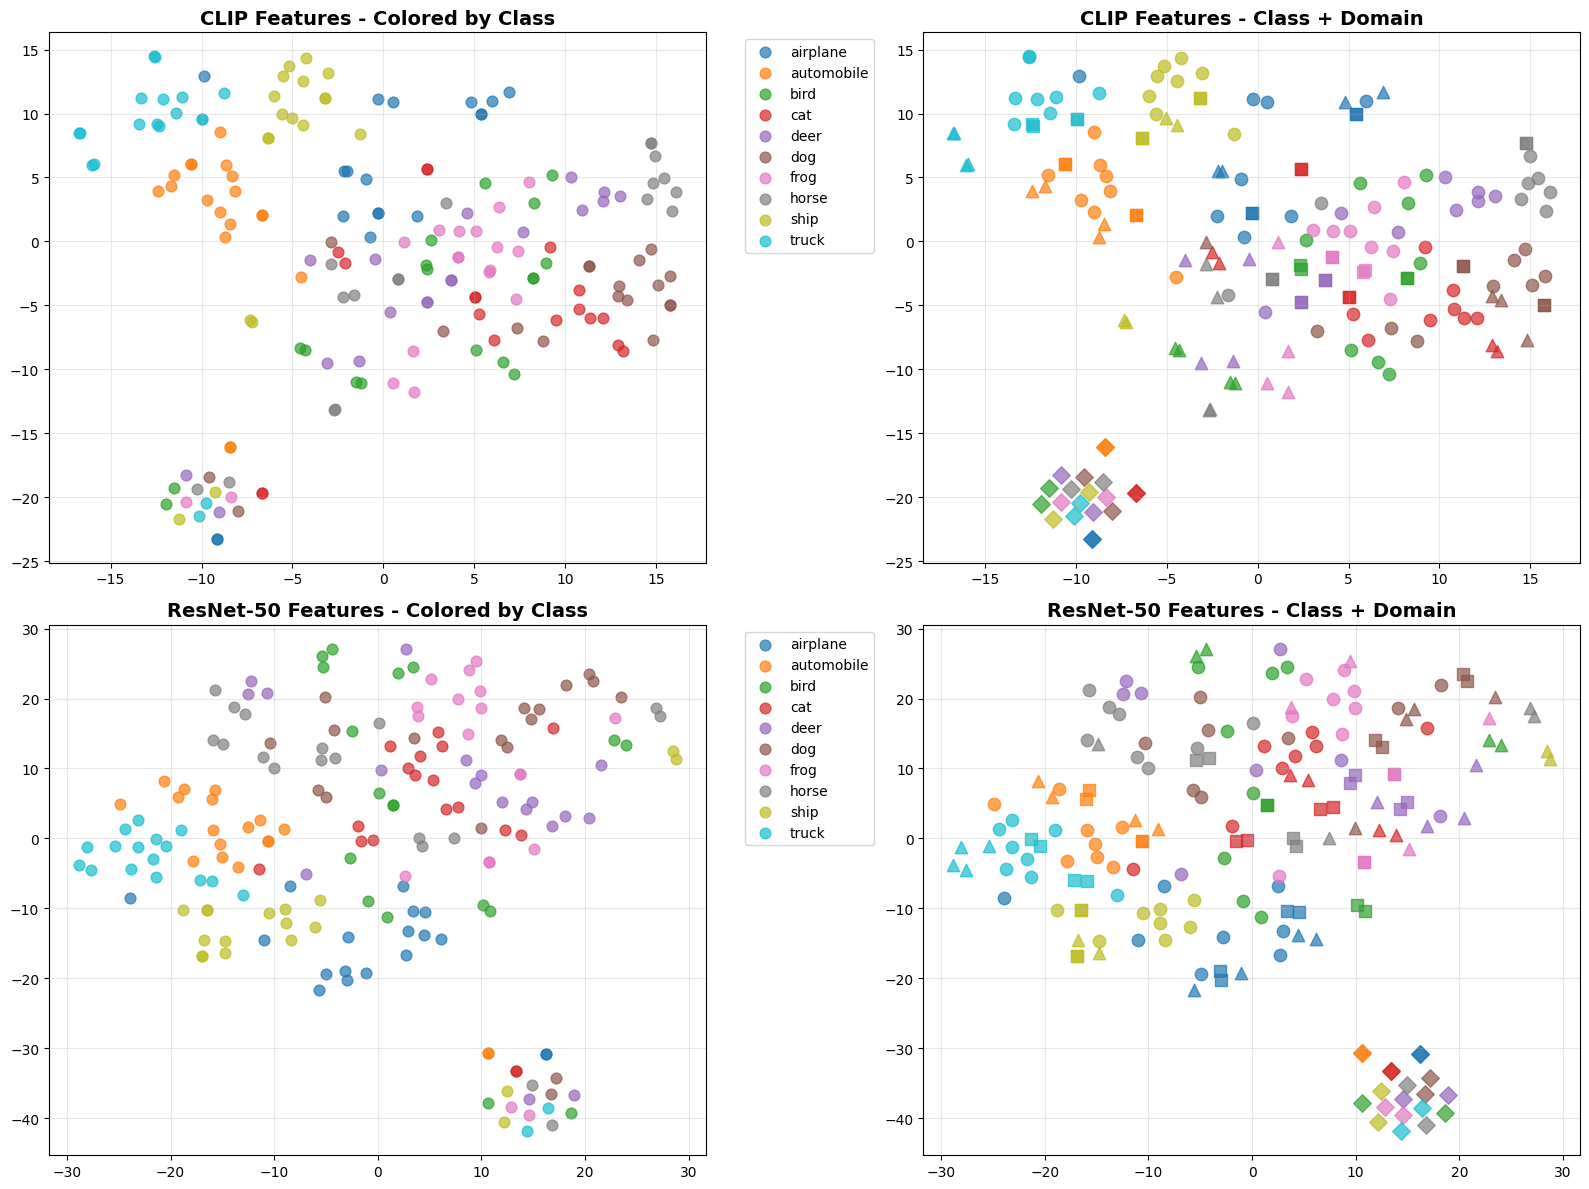


 CLUSTERING QUALITY ANALYSIS
Silhouette Scores (class-based clustering):
  CLIP:      0.005
  ResNet-50: -0.060
  Winner:    CLIP

Silhouette Scores (domain-based clustering):
  CLIP:      0.071
  ResNet-50: 0.084

 INTRA-CLASS COMPACTNESS:
  airplane    : CLIP=12.597, ResNet=13.783
  automobile  : CLIP=7.418, ResNet=14.499
  bird        : CLIP=11.976, ResNet=27.067
  cat         : CLIP=10.952, ResNet=17.700
  deer        : CLIP=11.993, ResNet=24.208
  dog         : CLIP=10.602, ResNet=23.490
  frog        : CLIP=9.690, ResNet=22.241
  horse       : CLIP=15.263, ResNet=25.687
  ship        : CLIP=11.464, ResNet=20.959
  truck       : CLIP=9.879, ResNet=16.457

Average intra-class distance:
  CLIP:      11.183 (lower = more compact)
  ResNet-50: 20.609


In [9]:
print(" FEATURE SPACE VISUALIZATION - CLIP VS SUPERVISED CNN")

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from torchvision.models import resnet50
import torchvision.models as models

def load_supervised_baseline():
    #Loading supervised baseline model (ResNet-50
    resnet = resnet50(pretrained=True)
    baseline_model = torch.nn.Sequential(*list(resnet.children())[:-1])
    baseline_model.eval()
    baseline_model = baseline_model.to(device)

    return baseline_model

def create_diverse_image_dataset():
    #Creating diverse image dataset for feature analysis
    diverse_images = []
    diverse_labels = []
    diverse_domains = []
    diverse_descriptions = []

    # 1. Regular CIFAR-10 images (8 per class → 80 images total)
    cifar_dataset = cifar10_testloader.dataset
    class_counts = {i: 0 for i in range(10)}

    for idx, (image, label) in enumerate(cifar_dataset):
        if class_counts[label] < 8:  # 8 images per class
            diverse_images.append(image)
            diverse_labels.append(label)
            diverse_domains.append('cifar10')
            diverse_descriptions.append(f"CIFAR-10 {cifar10_classes[label]}")
            class_counts[label] += 1

        if all(count >= 8 for count in class_counts.values()):
            break

    # 2. Create domain-shifted versions (4 per class → 80 images total)
    domain_shift_transforms = {
        'grayscale': transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                               (0.26862954, 0.26130258, 0.27577711))
        ]),
        'high_contrast': transforms.Compose([
            transforms.ColorJitter(brightness=0.3, contrast=2.0, saturation=0.3, hue=0.1),
            transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                               (0.26862954, 0.26130258, 0.27577711))
        ])
    }

    original_transform = transforms.Compose([
        transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                           (0.26862954, 0.26130258, 0.27577711))
    ])

    # we want 4 domain-shifted images per class: grayscale + high_contrast ×2 each
    class_counts = {i: 0 for i in range(10)}
    for idx, (image, label) in enumerate(cifar_dataset):
        if class_counts[label] < 2:  # 2 original images per class for domain shifting
            if torch.is_tensor(image):
                image = image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                image = transforms.ToPILImage()(torch.clamp(image, 0, 1))

            # adding two grayscale and two high-contrast images per class
            for _ in range(2):  # repeat twice per transform
                grayscale_image = domain_shift_transforms['grayscale'](image)
                diverse_images.append(grayscale_image)
                diverse_labels.append(label)
                diverse_domains.append('grayscale')
                diverse_descriptions.append(f"Grayscale {cifar10_classes[label]}")

                contrast_image = domain_shift_transforms['high_contrast'](image)
                diverse_images.append(contrast_image)
                diverse_labels.append(label)
                diverse_domains.append('high_contrast')
                diverse_descriptions.append(f"High-contrast {cifar10_classes[label]}")

            class_counts[label] += 1

        if all(count >= 2 for count in class_counts.values()):
            break

    # 3. synthetic sketches (2 per class → 20 images total)

    def create_sketch(class_name, class_idx, variant=1):
        """Create a simple sketch-like image with small variation"""
        img_size = 224
        sketch = Image.new('RGB', (img_size, img_size), color='white')
        pixels = np.array(sketch)
        cv = img_size // 2

        if class_name == 'airplane':
            pixels[cv-2:cv+3, 50:170] = [0, 0, 0]
            pixels[cv-20:cv+21, cv-5:cv+6] = [0, 0, 0]
        elif class_name == 'automobile':
            pixels[cv+20:cv+40, 60:160] = [0, 0, 0]
            pixels[cv+35:cv+45, 70:80] = [0, 0, 0]
            pixels[cv+35:cv+45, 140:150] = [0, 0, 0]
        elif class_name == 'cat':
            pixels[cv-10:cv+10, cv-10:cv+10] = [0, 0, 0]
            pixels[cv-15:cv-5, cv-15:cv-5] = [0, 0, 0]
            pixels[cv-15:cv-5, cv+5:cv+15] = [0, 0, 0]
        else:
            center = img_size // 2
            for i in range(5 + variant):  # vary number of dots
                y = center + np.random.randint(-30, 31)
                x = center + np.random.randint(-30, 31)
                pixels[max(0, y-5):min(img_size, y+6), max(0, x-5):min(img_size, x+6)] = [0, 0, 0]

        return Image.fromarray(pixels.astype(np.uint8))

    for class_idx, class_name in enumerate(cifar10_classes):
        for variant in [1, 2]:  # 2 sketches per class
            sketch_pil = create_sketch(class_name, class_idx, variant)
            sketch_tensor = original_transform(sketch_pil)
            diverse_images.append(sketch_tensor)
            diverse_labels.append(class_idx)
            diverse_domains.append('sketch')
            diverse_descriptions.append(f"Sketch {class_name} {variant}")

    print(f"Created diverse dataset with {len(diverse_images)} images")
    print(f"Domains: {set(diverse_domains)}")
    print(f"Classes: {len(set(diverse_labels))} unique classes")

    return diverse_images, diverse_labels, diverse_domains, diverse_descriptions


def extract_features(images, clip_model, baseline_model, device):
    """extracting features from both CLIP and baseline model"""

    clip_features = []
    baseline_features = []

    # processing images in batches
    batch_size = 8

    with torch.no_grad():
        for i in tqdm(range(0, len(images), batch_size), desc="Extracting features"):
            batch_images = images[i:i+batch_size]

            # stacking images into batch
            batch_tensor = torch.stack(batch_images).to(device)

            # CLIP features
            clip_batch_features = clip_model.encode_image(batch_tensor)
            clip_batch_features = F.normalize(clip_batch_features, dim=-1)
            clip_features.append(clip_batch_features.cpu())

            # Baseline features (ResNet)
            baseline_batch_features = baseline_model(batch_tensor)
            baseline_batch_features = baseline_batch_features.squeeze()  # remove spatial dimensions
            baseline_batch_features = F.normalize(baseline_batch_features, dim=-1)
            baseline_features.append(baseline_batch_features.cpu())

    clip_features = torch.cat(clip_features, dim=0).numpy()
    baseline_features = torch.cat(baseline_features, dim=0).numpy()

    print(f"   CLIP features shape: {clip_features.shape}")
    print(f"   Baseline features shape: {baseline_features.shape}")

    return clip_features, baseline_features

def apply_dimensionality_reduction(clip_features, baseline_features, method='tsne'):
    """applying t-SNE or PCA for 2D visualization"""
    print(f"Applying {method.upper()} dimensionality reduction...")

    if method == 'tsne':
        # t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(clip_features)-1))
        clip_2d = tsne.fit_transform(clip_features)

        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(baseline_features)-1))
        baseline_2d = tsne.fit_transform(baseline_features)

    elif method == 'pca':
        # PCA
        pca = PCA(n_components=2, random_state=42)
        clip_2d = pca.fit_transform(clip_features)

        pca = PCA(n_components=2, random_state=42)
        baseline_2d = pca.fit_transform(baseline_features)

    print(f" {method.upper()} completed!")
    return clip_2d, baseline_2d

def visualize_feature_spaces(clip_2d, baseline_2d, labels, domains, descriptions, class_names):
    """Visualize the 2D feature spaces"""
    print("Creating feature space visualizations...")

    # Define colors and markers
    class_colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))
    domain_markers = {'cifar10': 'o', 'grayscale': 's', 'high_contrast': '^', 'sketch': 'D'}

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: CLIP features colored by class
    ax = axes[0, 0]
    for class_idx in range(len(class_names)):
        mask = np.array(labels) == class_idx
        if np.any(mask):
            ax.scatter(clip_2d[mask, 0], clip_2d[mask, 1],
                      c=[class_colors[class_idx]], label=class_names[class_idx],
                      alpha=0.7, s=60)

    ax.set_title('CLIP Features - Colored by Class', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)

    # Plot 2: CLIP features shaped by domain
    ax = axes[0, 1]
    for domain in domain_markers.keys():
        domain_mask = np.array(domains) == domain
        if np.any(domain_mask):
            domain_labels = np.array(labels)[domain_mask]
            for class_idx in range(len(class_names)):
                class_mask = domain_labels == class_idx
                if np.any(class_mask):
                    full_mask = domain_mask.copy()
                    full_mask[domain_mask] = class_mask
                    ax.scatter(clip_2d[full_mask, 0], clip_2d[full_mask, 1],
                              c=[class_colors[class_idx]], marker=domain_markers[domain],
                              label=f'{class_names[class_idx]}-{domain}' if domain != 'cifar10' else class_names[class_idx],
                              alpha=0.7, s=80)

    ax.set_title('CLIP Features - Class + Domain', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Plot 3: Baseline features colored by class
    ax = axes[1, 0]
    for class_idx in range(len(class_names)):
        mask = np.array(labels) == class_idx
        if np.any(mask):
            ax.scatter(baseline_2d[mask, 0], baseline_2d[mask, 1],
                      c=[class_colors[class_idx]], label=class_names[class_idx],
                      alpha=0.7, s=60)

    ax.set_title('ResNet-50 Features - Colored by Class', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)

    # Plot 4: Baseline features shaped by domain
    ax = axes[1, 1]
    for domain in domain_markers.keys():
        domain_mask = np.array(domains) == domain
        if np.any(domain_mask):
            domain_labels = np.array(labels)[domain_mask]
            for class_idx in range(len(class_names)):
                class_mask = domain_labels == class_idx
                if np.any(class_mask):
                    full_mask = domain_mask.copy()
                    full_mask[domain_mask] = class_mask
                    ax.scatter(baseline_2d[full_mask, 0], baseline_2d[full_mask, 1],
                              c=[class_colors[class_idx]], marker=domain_markers[domain],
                              alpha=0.7, s=80)

    ax.set_title('ResNet-50 Features - Class + Domain', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def analyze_clustering_quality(clip_2d, baseline_2d, labels, domains):
    """Analyze clustering quality using silhouette score and intra-class distances"""
    from sklearn.metrics import silhouette_score
    from scipy.spatial.distance import pdist, squareform

    print("\n CLUSTERING QUALITY ANALYSIS")
    print("="*50)

    # Silhouette scores
    if len(set(labels)) > 1:
        clip_silhouette = silhouette_score(clip_2d, labels)
        baseline_silhouette = silhouette_score(baseline_2d, labels)

        print(f"Silhouette Scores (class-based clustering):")
        print(f"  CLIP:      {clip_silhouette:.3f}")
        print(f"  ResNet-50: {baseline_silhouette:.3f}")
        print(f"  Winner:    {'CLIP' if clip_silhouette > baseline_silhouette else 'ResNet-50'}")

    # Analyze domain separation
    unique_domains = list(set(domains))
    if len(unique_domains) > 1:
        clip_domain_silhouette = silhouette_score(clip_2d, domains)
        baseline_domain_silhouette = silhouette_score(baseline_2d, domains)

        print(f"\nSilhouette Scores (domain-based clustering):")
        print(f"  CLIP:      {clip_domain_silhouette:.3f}")
        print(f"  ResNet-50: {baseline_domain_silhouette:.3f}")

    # Intra-class compactness analysis
    print(f"\n INTRA-CLASS COMPACTNESS:")
    clip_intra_distances = []
    baseline_intra_distances = []

    for class_idx in range(len(cifar10_classes)):
        class_mask = np.array(labels) == class_idx
        if np.sum(class_mask) > 1:  # Need at least 2 points
            clip_class_points = clip_2d[class_mask]
            baseline_class_points = baseline_2d[class_mask]

            clip_distances = pdist(clip_class_points)
            baseline_distances = pdist(baseline_class_points)

            clip_intra_distances.append(np.mean(clip_distances))
            baseline_intra_distances.append(np.mean(baseline_distances))

            print(f"  {cifar10_classes[class_idx]:12}: CLIP={np.mean(clip_distances):.3f}, ResNet={np.mean(baseline_distances):.3f}")

    if clip_intra_distances and baseline_intra_distances:
        avg_clip_intra = np.mean(clip_intra_distances)
        avg_baseline_intra = np.mean(baseline_intra_distances)

        print(f"\nAverage intra-class distance:")
        print(f"  CLIP:      {avg_clip_intra:.3f} (lower = more compact)")
        print(f"  ResNet-50: {avg_baseline_intra:.3f}")

    return {
        'clip_silhouette': clip_silhouette if 'clip_silhouette' in locals() else None,
        'baseline_silhouette': baseline_silhouette if 'baseline_silhouette' in locals() else None,
        'clip_intra_distance': avg_clip_intra if 'avg_clip_intra' in locals() else None,
        'baseline_intra_distance': avg_baseline_intra if 'avg_baseline_intra' in locals() else None
    }


# executing feature Space Visualization

# load baseline supervised model
baseline_model = load_supervised_baseline()

# create diverse image dataset
diverse_images, diverse_labels, diverse_domains, diverse_descriptions = create_diverse_image_dataset()

# extract features from both models
clip_features, baseline_features = extract_features(diverse_images, model, baseline_model, device)

# applying t-SNE dimensionality reduction
clip_2d, baseline_2d = apply_dimensionality_reduction(clip_features, baseline_features, method='tsne')

# visualize feature spaces
visualize_feature_spaces(clip_2d, baseline_2d, diverse_labels, diverse_domains,
                        diverse_descriptions, cifar10_classes)

# analyze clustering quality
clustering_metrics = analyze_clustering_quality(clip_2d, baseline_2d, diverse_labels, diverse_domains)

# Store results for final analysis
task5_results = {
    'clip_silhouette_score': clustering_metrics['clip_silhouette'],
    'baseline_silhouette_score': clustering_metrics['baseline_silhouette'],
    'dataset_diversity': len(set(diverse_domains)),
    'total_images_analyzed': len(diverse_images),
    'semantic_clustering_winner': 'CLIP' if clustering_metrics['clip_silhouette'] > clustering_metrics['baseline_silhouette'] else 'ResNet-50'
}

### Texture vs Shape

Saving catshape-elephanttexture.png to catshape-elephanttexture.png


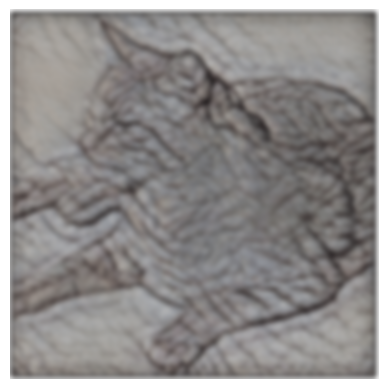

In [10]:
from google.colab import files
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

# Upload the PNG file
uploaded = files.upload()  # this opens a file picker
filename = list(uploaded.keys())[0]

# Open the uploaded image
stylized_image = Image.open(filename).convert("RGB")

# Apply a blur filter (GaussianBlur)
blurred_image = stylized_image.filter(ImageFilter.GaussianBlur(radius=5))

# Preview blurred image
plt.imshow(blurred_image)
plt.axis("off")
plt.show()


In [14]:
# Text prompts to compare
text_prompts = ["a cat", "an elephant"]
text_tokens = clip.tokenize(text_prompts).to(device)

with torch.no_grad():
    # Encode text
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Preprocess and encode the uploaded image
    image = preprocess(blurred_image).unsqueeze(0).to(device)
    image_feature = model.encode_image(image)
    image_feature /= image_feature.norm(dim=-1, keepdim=True)

    # Similarity (softmax gives probabilities)
    sims = (image_feature @ text_features.T).softmax(dim=-1)

print("CLIP's Prediction", "P(cat):", sims[0, 0].item(), "P(elephant):", sims[0, 1].item())


CLIP's Prediction P(cat): 0.50732421875 P(elephant): 0.49267578125


In [15]:
##checking the image on Resnet

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import requests

device = "cuda" if torch.cuda.is_available() else "cpu"

# loading pretrained ResNet50 model
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet.eval().to(device)

# standard ImageNet preprocessing
imagenet_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    ),
])

# path of the famous catshape-elephant texture image
uploaded_image_path = 'catshape-elephanttexture.png'
image = Image.open(uploaded_image_path).convert('RGB')
input_tensor = imagenet_preprocess(image).unsqueeze(0).to(device)

# Run ResNet
with torch.no_grad():
    outputs = resnet(input_tensor)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    top5_prob, top5_catid = torch.topk(probs, 5)

# Get ImageNet labels
labels_url = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
imagenet_classes = requests.get(labels_url).text.strip().split('\n')

# Show top 5 predictions
print("Top 5 ResNet50 predictions for your image:")
for i in range(top5_prob.size(1)):
    print(f"{imagenet_classes[top5_catid[0][i]]}: {top5_prob[0][i].item()*100:.2f}%")


Top 5 ResNet50 predictions for your image:
African elephant: 60.92%
Indian elephant: 23.44%
tusker: 15.62%
warthog: 0.01%
triceratops: 0.00%


TEST ON NOISY DATA FOR ROBUSTNESS CHECK


Image 1 - Original (GT: bird)
  CLIP: a photo of a bird Prob: 0.1035
  ResNet top5:
     rock beauty (0.2378)
     agama (0.0457)
     banded gecko (0.0445)
     black grouse (0.0301)
     whiptail (0.0224)

Image 1 - Noisy (GT: bird)
  CLIP: a photo of a bird Prob: 0.1031
  ResNet top5:
     black widow (0.1149)
     leafhopper (0.0650)
     leaf beetle (0.0561)
     weevil (0.0456)
     agama (0.0455)

Image 1 - Blurred (GT: bird)
  CLIP: a photo of a bird Prob: 0.1033
  ResNet top5:
     rock beauty (0.1994)
     agama (0.0493)
     banded gecko (0.0490)
     black grouse (0.0281)
     wood rabbit (0.0247)


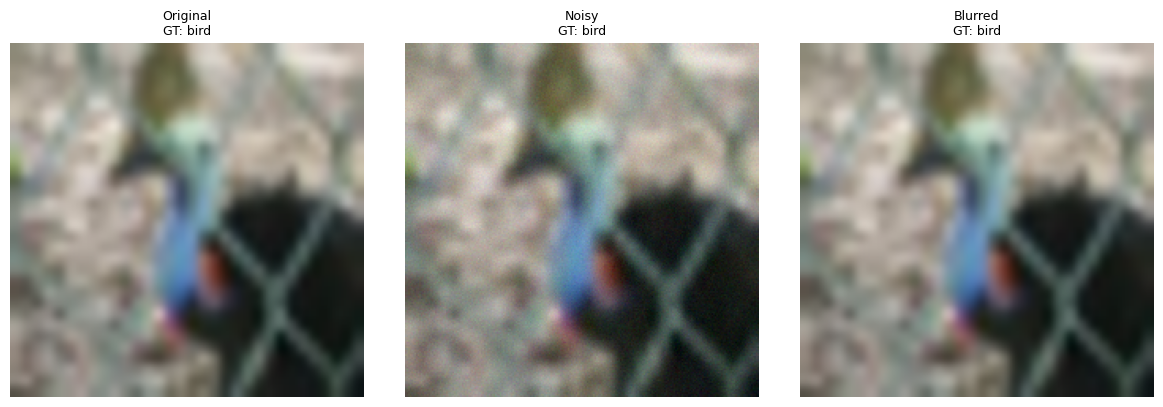


Image 2 - Original (GT: frog)
  CLIP: a photo of a frog Prob: 0.1074
  ResNet top5:
     strawberry (0.1565)
     plate (0.0851)
     hot pot (0.0717)
     packet (0.0292)
     goldfish (0.0272)

Image 2 - Noisy (GT: frog)
  CLIP: a photo of a frog Prob: 0.1089
  ResNet top5:
     tree frog (0.3301)
     strawberry (0.0730)
     ladybug (0.0612)
     eft (0.0611)
     trifle (0.0526)

Image 2 - Blurred (GT: frog)
  CLIP: a photo of a frog Prob: 0.1073
  ResNet top5:
     strawberry (0.1792)
     plate (0.0858)
     hot pot (0.0698)
     trifle (0.0328)
     goldfish (0.0267)


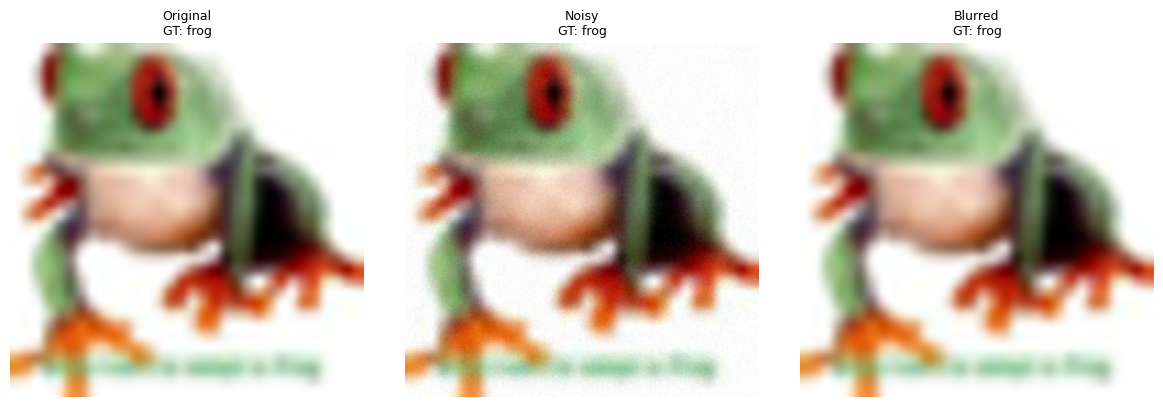


Image 3 - Original (GT: automobile)
  CLIP: a photo of a automobile Prob: 0.1057
  ResNet top5:
     moving van (0.3877)
     minibus (0.2140)
     sports car (0.0611)
     cassette player (0.0371)
     passenger car (0.0365)

Image 3 - Noisy (GT: automobile)
  CLIP: a photo of a automobile Prob: 0.1069
  ResNet top5:
     whistle (0.2823)
     cellular telephone (0.1252)
     harmonica (0.0712)
     safety pin (0.0596)
     lighter (0.0333)

Image 3 - Blurred (GT: automobile)
  CLIP: a photo of a automobile Prob: 0.1057
  ResNet top5:
     moving van (0.3428)
     minibus (0.2264)
     sports car (0.0702)
     passenger car (0.0426)
     cassette player (0.0365)


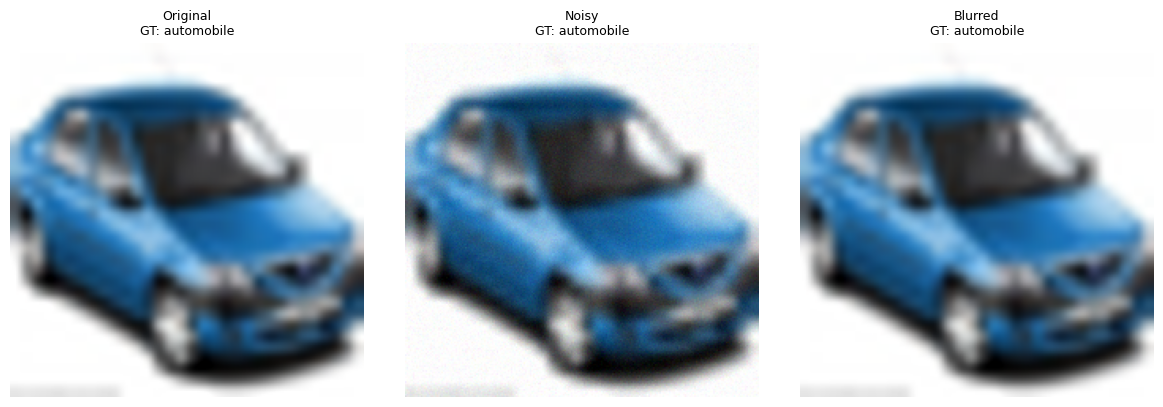


Image 4 - Original (GT: automobile)
  CLIP: a photo of a automobile Prob: 0.1058
  ResNet top5:
     chain saw (0.8355)
     amphibian (0.0306)
     thresher (0.0226)
     moving van (0.0221)
     sports car (0.0206)

Image 4 - Noisy (GT: automobile)
  CLIP: a photo of a automobile Prob: 0.106
  ResNet top5:
     racer (0.0983)
     car mirror (0.0965)
     web site (0.0435)
     cab (0.0266)
     television (0.0250)

Image 4 - Blurred (GT: automobile)
  CLIP: a photo of a automobile Prob: 0.1057
  ResNet top5:
     chain saw (0.7898)
     amphibian (0.0309)
     moving van (0.0292)
     sports car (0.0276)
     thresher (0.0269)


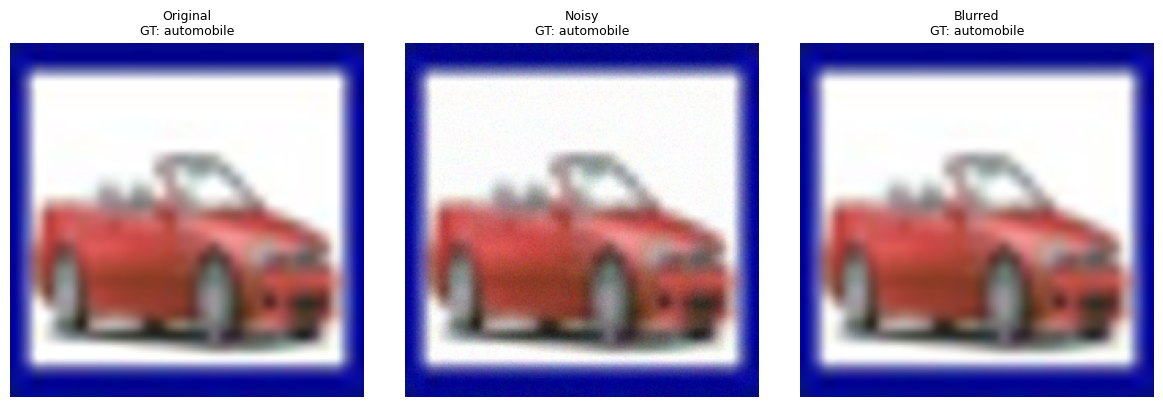


Image 5 - Original (GT: horse)
  CLIP: a photo of a horse Prob: 0.1065
  ResNet top5:
     Sealyham terrier (0.1159)
     safety pin (0.0627)
     muzzle (0.0368)
     studio couch (0.0350)
     komondor (0.0323)

Image 5 - Noisy (GT: horse)
  CLIP: a photo of a horse Prob: 0.1075
  ResNet top5:
     nail (0.0397)
     chime (0.0288)
     hook (0.0272)
     screw (0.0262)
     whistle (0.0189)

Image 5 - Blurred (GT: horse)
  CLIP: a photo of a horse Prob: 0.1064
  ResNet top5:
     Sealyham terrier (0.1183)
     safety pin (0.0641)
     muzzle (0.0368)
     studio couch (0.0327)
     komondor (0.0294)


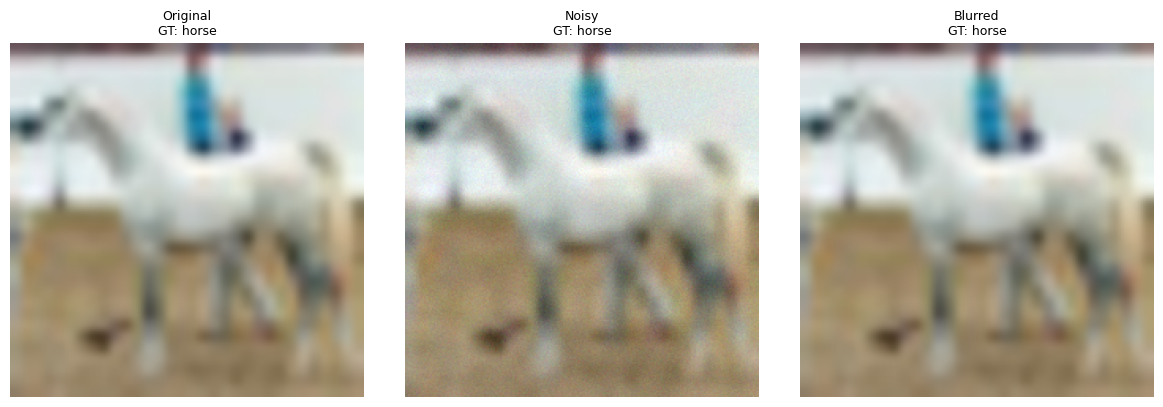


Image 6 - Original (GT: bird)
  CLIP: a photo of a horse Prob: 0.1051
  ResNet top5:
     black grouse (0.2366)
     hartebeest (0.2123)
     black stork (0.1395)
     EntleBucher (0.0831)
     colobus (0.0367)

Image 6 - Noisy (GT: bird)
  CLIP: a photo of a horse Prob: 0.1037
  ResNet top5:
     black grouse (0.1084)
     ostrich (0.0706)
     hornbill (0.0679)
     magpie (0.0664)
     vulture (0.0418)

Image 6 - Blurred (GT: bird)
  CLIP: a photo of a horse Prob: 0.105
  ResNet top5:
     black grouse (0.2305)
     hartebeest (0.2059)
     black stork (0.1253)
     EntleBucher (0.0750)
     colobus (0.0447)


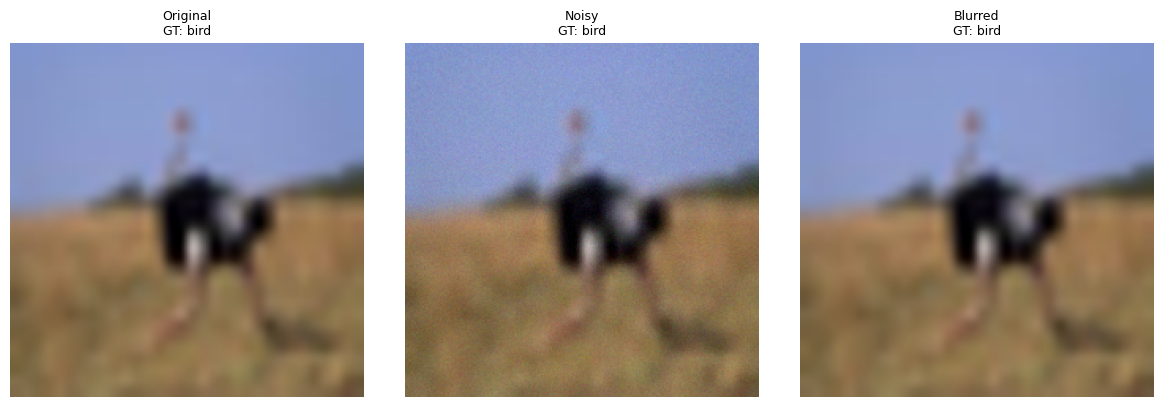


Image 7 - Original (GT: truck)
  CLIP: a photo of a truck Prob: 0.1057
  ResNet top5:
     moving van (0.4824)
     thresher (0.2864)
     garbage truck (0.0724)
     trailer truck (0.0486)
     snowplow (0.0238)

Image 7 - Noisy (GT: truck)
  CLIP: a photo of a truck Prob: 0.1058
  ResNet top5:
     bottlecap (0.0652)
     whistle (0.0552)
     lighter (0.0478)
     rubber eraser (0.0289)
     lens cap (0.0243)

Image 7 - Blurred (GT: truck)
  CLIP: a photo of a truck Prob: 0.1057
  ResNet top5:
     moving van (0.4433)
     thresher (0.3070)
     garbage truck (0.0737)
     trailer truck (0.0501)
     snowplow (0.0281)


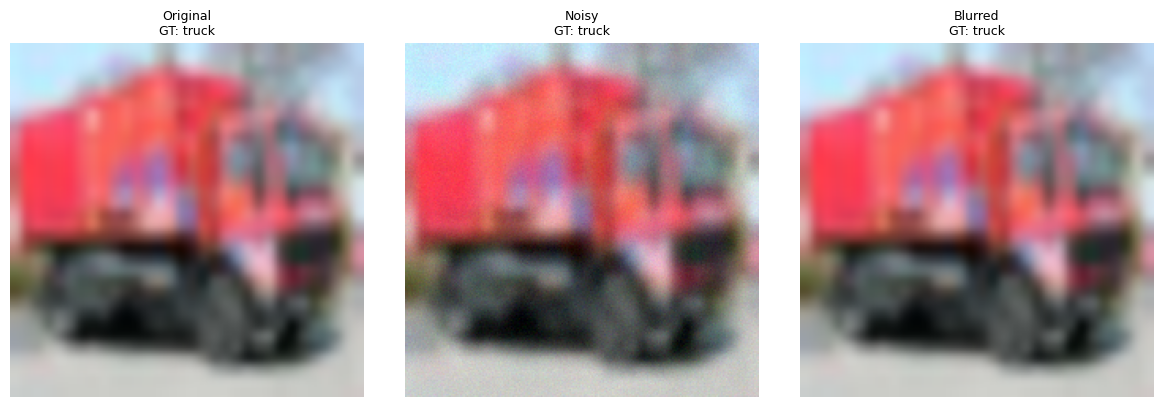


Image 8 - Original (GT: automobile)
  CLIP: a photo of a automobile Prob: 0.1033
  ResNet top5:
     tobacco shop (0.3074)
     waffle iron (0.2091)
     potpie (0.0682)
     moving van (0.0506)
     toyshop (0.0431)

Image 8 - Noisy (GT: automobile)
  CLIP: a photo of a automobile Prob: 0.1042
  ResNet top5:
     bookshop (0.0361)
     grocery store (0.0350)
     packet (0.0306)
     lens cap (0.0274)
     Band Aid (0.0274)

Image 8 - Blurred (GT: automobile)
  CLIP: a photo of a automobile Prob: 0.1035
  ResNet top5:
     tobacco shop (0.3294)
     waffle iron (0.1680)
     potpie (0.0822)
     toyshop (0.0459)
     moving van (0.0410)


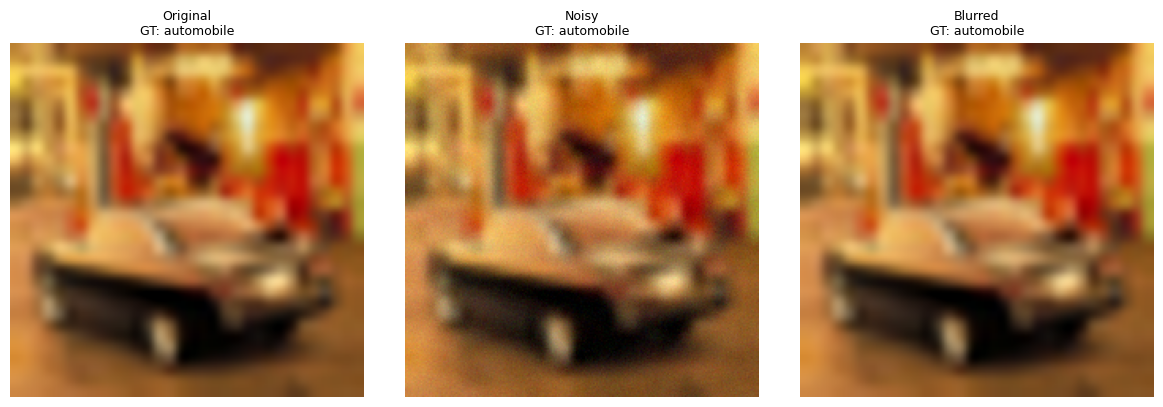


Image 9 - Original (GT: automobile)
  CLIP: a photo of a automobile Prob: 0.1057
  ResNet top5:
     moving van (0.3559)
     amphibian (0.0743)
     tobacco shop (0.0645)
     sports car (0.0502)
     cassette player (0.0400)

Image 9 - Noisy (GT: automobile)
  CLIP: a photo of a automobile Prob: 0.1057
  ResNet top5:
     remote control (0.2148)
     jigsaw puzzle (0.1577)
     cab (0.0410)
     jean (0.0236)
     bottlecap (0.0228)

Image 9 - Blurred (GT: automobile)
  CLIP: a photo of a automobile Prob: 0.1056
  ResNet top5:
     moving van (0.3740)
     tobacco shop (0.0613)
     amphibian (0.0593)
     sports car (0.0438)
     cassette player (0.0321)


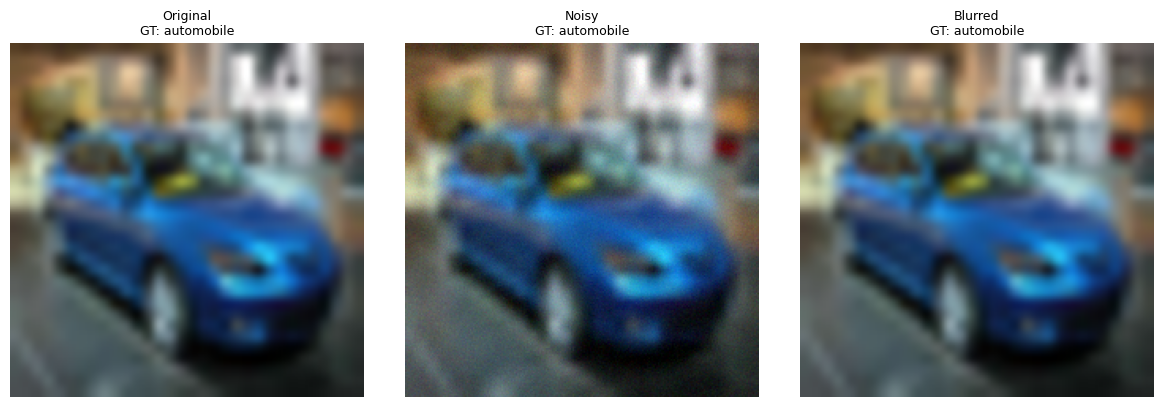


Image 10 - Original (GT: ship)
  CLIP: a photo of a ship Prob: 0.1045
  ResNet top5:
     speedboat (0.9147)
     yawl (0.0146)
     submarine (0.0131)
     lifeboat (0.0126)
     paddle (0.0108)

Image 10 - Noisy (GT: ship)
  CLIP: a photo of a ship Prob: 0.1033
  ResNet top5:
     speedboat (0.1819)
     submarine (0.0909)
     container ship (0.0218)
     parachute (0.0215)
     warplane (0.0212)

Image 10 - Blurred (GT: ship)
  CLIP: a photo of a ship Prob: 0.1044
  ResNet top5:
     speedboat (0.8932)
     yawl (0.0192)
     paddle (0.0153)
     submarine (0.0145)
     lifeboat (0.0140)


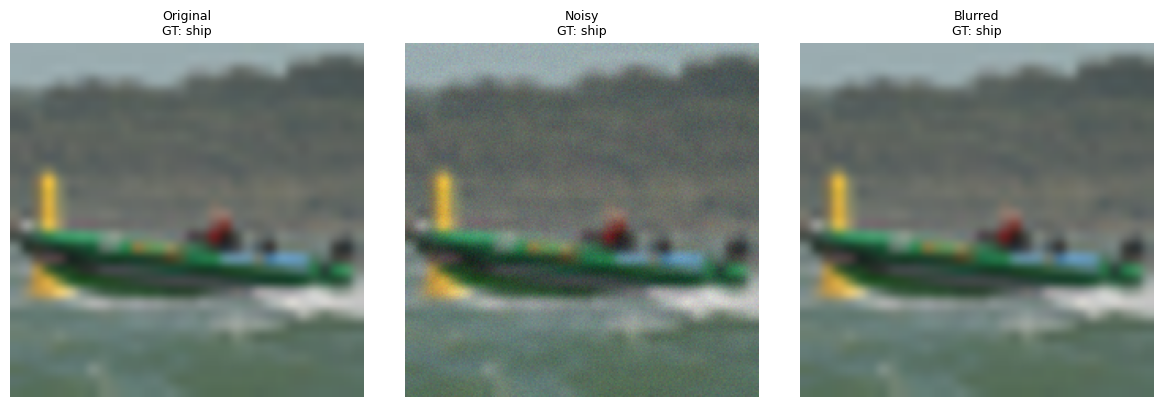

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import clip
from PIL import Image, ImageFilter
import numpy as np
import requests
import matplotlib.pyplot as plt
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---- Load models ----
# CLIP
model, preprocess = clip.load("ViT-B/32", device=device)

# ResNet
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet.eval().to(device)

# ImageNet preprocessing for ResNet
imagenet_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# ---- Load CIFAR-10 ----
cifar_transform = transforms.ToTensor()  # no normalization for now
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=cifar_transform)

# Take 10 random indices
indices = random.sample(range(len(cifar10)), 10)
subset = [cifar10[i] for i in indices]

# CIFAR-10 class names
cifar_classes = cifar10.classes

# ---- CLIP text prompts ----
text_prompts = [f"a photo of a {cls}" for cls in cifar_classes]
text_tokens = clip.tokenize(text_prompts).to(device)

def clip_predict(img):
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        image = preprocess(img).unsqueeze(0).to(device)
        image_feature = model.encode_image(image)
        image_feature /= image_feature.norm(dim=-1, keepdim=True)

        sims = (image_feature @ text_features.T).softmax(dim=-1)
    return sims.cpu().numpy()

# ---- ResNet Predictions ----
labels_url = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
imagenet_classes = requests.get(labels_url).text.strip().split('\n')

def resnet_predict(img):
    with torch.no_grad():
        inp = imagenet_preprocess(img).unsqueeze(0).to(device)
        outputs = resnet(inp)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        top5_prob, top5_catid = torch.topk(probs, 5)
    preds = [(imagenet_classes[top5_catid[0][i]], top5_prob[0][i].item()) for i in range(5)]
    return preds

# ---- Perturbation functions (gentler) ----
def add_noise(img, std=12):  # much less noise
    np_img = np.array(img).astype(np.float32)
    noise = np.random.normal(0, std, np_img.shape)
    noisy_img = np.clip(np_img + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_img)

def blur_img(img, radius=2):  # mild blur
    return img.filter(ImageFilter.GaussianBlur(radius=radius))

# ---- Run test ----
for idx, (img_tensor, label) in enumerate(subset):
    # Convert tensor to PIL and upscale to 224 for perturbation stability
    img_pil = transforms.ToPILImage()(img_tensor).resize((224, 224), Image.BICUBIC)

    # Create perturbations
    noisy_pil = add_noise(img_pil, std=5)
    blurred_pil = blur_img(img_pil, radius=1)

    # Store images & names
    images_to_test = {
        "Original": img_pil,
        "Noisy": noisy_pil,
        "Blurred": blurred_pil,
    }

    plt.figure(figsize=(12, 4))
    for j, (name, pil_img) in enumerate(images_to_test.items(), 1):
        clip_probs = clip_predict(pil_img)
        resnet_preds = resnet_predict(pil_img)

        # Show image
        plt.subplot(1, 3, j)
        plt.imshow(pil_img)
        plt.axis('off')
        plt.title(f"{name}\nGT: {cifar_classes[label]}", fontsize=9)

        # Print predictions in console
        print(f"\nImage {idx+1} - {name} (GT: {cifar_classes[label]})")
        top_idx = clip_probs.argmax()
        print("  CLIP:", text_prompts[top_idx], "Prob:", round(float(clip_probs[0, top_idx]), 4))
        print("  ResNet top5:")
        for cls, prob in resnet_preds:
            print(f"     {cls} ({prob:.4f})")

    plt.tight_layout()
    plt.show()
